# Goal of the notebook

Evaluate which spectra any state-of-the-art algorithm still cannot predict well.

Only keep the optimal predictions in following order:
- Match
- Higher score
- isobaric_peak
- Lower score


The causes for why these models keep on failing on these ones will be evaluted:

- Missing fragmentation sites
- Explained intensity in percent
- Length of the peptide
- Charge state

Also, to really show that these spectra are less optimal, plot the scores for these compared to well predicted ones.

In [143]:
from peak_pack.feature_generators import PeakFeatureGenerator

In [36]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.io.read import load_psmlist, load_features

from Levenshtein import editops # To track actions for transpositions
from nltk import edit_distance # For Damerau–Levenshtein distance

import numpy as np
import pandas as pd

# 1. Load the data

In [12]:
root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'
root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    # Load a ground-truth
    psmlist_gt = load_psmlist(os.path.join(
        root_results_dn, run_name, 'psmlist', 'ground_truth.parquet'
    ))
    # parser = DenovoEngineConverter.select('sage')
    # psmlist_gt = parser.parse(
    #     result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
    #     mgf_path=mgf_path
    # )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=['score_ms2rescore'],
        is_ground_truth=True
    )

    # Load the de novo results
    for engine_name in engine_names:
        print(f'loading {engine_name}')
        dn_path = os.path.join(root_results_dn, run_name, 'psmlist', engine_name + '.parquet')
        
        psmlist_denovo = load_psmlist(psm_path=dn_path)
        
        # parser = DenovoEngineConverter.select(engine_name)
        # psmlist_denovo = parser.parse(
        #     result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
        #     mgf_path=mgf_path
        # )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=['score_ms2rescore'],
            is_ground_truth=False
        )
    
    runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:00<00:00, 59986.56it/s]


loading adanovo


100%|██████████| 61843/61843 [00:00<00:00, 137185.31it/s]


loading pihelixnovo


100%|██████████| 61955/61955 [00:00<00:00, 139326.41it/s]


loading piprimenovo


100%|██████████| 58682/58682 [00:00<00:00, 140209.31it/s]


loading casanovo


100%|██████████| 61876/61876 [00:00<00:00, 129843.75it/s]


loading instanovo


100%|██████████| 61562/61562 [00:00<00:00, 143495.94it/s]


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 126841.22it/s]


loading novob


100%|██████████| 61479/61479 [00:00<00:00, 144992.50it/s]


loading pepnet


100%|██████████| 62560/62560 [00:00<00:00, 152753.31it/s]


Run: LFQ_Orbitrap_DDA_Human_01


100%|██████████| 90817/90817 [00:01<00:00, 54585.67it/s]


loading adanovo


100%|██████████| 115178/115178 [00:07<00:00, 16372.74it/s]


loading pihelixnovo


100%|██████████| 115417/115417 [00:01<00:00, 64252.28it/s]


loading piprimenovo


100%|██████████| 111287/111287 [00:01<00:00, 66630.01it/s]


loading casanovo


100%|██████████| 115362/115362 [00:01<00:00, 61733.07it/s]


loading instanovo


100%|██████████| 114725/114725 [00:01<00:00, 67305.12it/s]


loading contranovo


100%|██████████| 57640/57640 [00:00<00:00, 60176.59it/s]


loading novob


100%|██████████| 114064/114064 [00:01<00:00, 66854.35it/s]


loading pepnet


100%|██████████| 118245/118245 [00:01<00:00, 71666.45it/s]


Run: LFQ_Orbitrap_DDA_QC_01


100%|██████████| 83941/83941 [00:01<00:00, 56432.74it/s]


loading adanovo


100%|██████████| 107088/107088 [00:01<00:00, 68370.07it/s]


loading pihelixnovo


100%|██████████| 107182/107182 [00:01<00:00, 64310.03it/s]


loading piprimenovo


100%|██████████| 103511/103511 [00:01<00:00, 68276.68it/s]


loading casanovo


100%|██████████| 107203/107203 [00:01<00:00, 63937.30it/s]


loading instanovo


100%|██████████| 106604/106604 [00:01<00:00, 68692.17it/s]


loading contranovo


100%|██████████| 53533/53533 [00:16<00:00, 3226.30it/s] 


loading novob


100%|██████████| 106075/106075 [00:01<00:00, 69709.19it/s]


loading pepnet


100%|██████████| 109340/109340 [00:01<00:00, 70384.14it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 67111/67111 [00:01<00:00, 64549.48it/s]


loading adanovo


100%|██████████| 102427/102427 [00:01<00:00, 89176.69it/s]


loading pihelixnovo


100%|██████████| 102483/102483 [00:01<00:00, 85317.66it/s]


loading piprimenovo


100%|██████████| 96975/96975 [00:01<00:00, 89653.96it/s] 


loading casanovo


100%|██████████| 102518/102518 [00:01<00:00, 84501.31it/s]


loading instanovo


100%|██████████| 101883/101883 [00:01<00:00, 91574.71it/s]


loading contranovo


100%|██████████| 51215/51215 [00:00<00:00, 81823.64it/s] 


loading novob


100%|██████████| 101183/101183 [00:23<00:00, 4314.95it/s] 


loading pepnet


100%|██████████| 103785/103785 [00:01<00:00, 96464.23it/s]


The peptide evidence objects were built with all available ions and is very lenient.

They were built with a - z ions both singly and doubly charged including water losses.

Here, we will rebuilt these peptide evidence matrices with only b and y ions (singly/doubly charged)

In [150]:
os.path.join(root_mgf, run_name + '.mgf')

'/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted/LFQ_Orbitrap_DDA_Yeast_01.mgf'

In [153]:
from denovo_utils.io.save import save_features, save_psmlist
from peak_pack.feature_generators import MissingFragmentationFeatures

output_path = '/public/compomics3/Sam/PXD028735/QExactive/peptide_evidence_gt'
for run_name in run_names:

    psmlist_gt = load_psmlist(os.path.join(
        root_results_dn, run_name, 'psmlist', 'ground_truth.parquet'
    ))
    config = {
        'spectrum_path': os.path.join(root_mgf, run_name + '.mgf'),
        'max_workers': 8,
        'ion_types': ["b1","b2","y1","y2"],
        'neutral_losses': [''],
        'ion_types_evidence': ['b1', 'y1', 'b2', 'y2'],
        'neutral_losses_evidence': [''],
        'fragment_tol_mass': 20,
        'fragment_tol_mode': 'ppm',
        'spectrum_format': 'mgf'
    }
    peak_fgen = PeakFeatureGenerator(**config)
    peak_fgen.fgens = [
        MissingFragmentationFeatures(**config)
    ]
    psmlist_gt_copy = psmlist_gt.model_copy()
    peak_fgen.add_features(psmlist_gt_copy)

    dirname = os.path.join(output_path, run_name, 'features')
    dirname_psmlist = os.path.join(output_path, run_name, 'psmlist')
    os.makedirs(dirname, exist_ok=True)
    save_features(psmlist_gt_copy, os.path.join(dirname, 'ground_truth.parquet'))
    save_psmlist(psmlist_gt_copy, os.path.join(dirname_psmlist, 'ground_truth.parquet'))

100%|██████████| 24285/24285 [05:04<00:00, 79.75it/s]
24285it [00:00, 31886.86it/s]
100%|██████████| 90817/90817 [18:07<00:00, 83.54it/s] 
90817it [00:02, 33458.08it/s]
100%|██████████| 83941/83941 [17:39<00:00, 79.20it/s]
83941it [00:02, 32362.31it/s]
100%|██████████| 67111/67111 [13:32<00:00, 82.59it/s]
67111it [00:01, 33773.55it/s]


In [13]:
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        gt_score = spectrum.psm_gt.scores.get_score('sage')
        spectrum.psm_gt.scores.add_score(
            score=gt_score,
            metadata='score_ms2rescore',
            score_type='peptide'
        )
        spectrum.compare_gt(
            'score_ms2rescore',
            ignore_score=False
        )

100%|██████████| 43131/43131 [00:28<00:00, 1497.84it/s]


# 2. Create the optimal set

Barplot showing counts the prediction of a given tool was selected

--> Choose highest lower scoring one

In [158]:
def filter_highest_scoring_psms(collection, score_type):
    highest = collection[
        np.array(
            [psm.scores.get_score(score_type) for psm in collection]
        ).argmax()
    ]
    return [psm for psm in collection if psm.peptidoform == highest.peptidoform]

def collect_psms(psm_candidates, error_type, score_type='score_ms2rescore'):

    collection = [psm for psm in psm_candidates if psm.evaluation[score_type].error_type==error_type]
    if len(collection) > 0:
        # All psms that match are the same by definition
        if error_type != 'match':
            collection = filter_highest_scoring_psms(collection, score_type)
        return collection

    else:
        return []


evaluation_order = [
    'match',
    'Higher score',
    'isobaric_aa',
    'isobaric_peak',
    'Lower score'
]


for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        for evaluation in evaluation_order:
            collection = collect_psms(
                psm_candidates=spectrum.psm_candidates,
                error_type=evaluation,
                score_type='score_ms2rescore'
            )
            if len(collection) > 0:
                break
    
        spectrum.properties['denovo_selection'] = [psm.engine_name for psm in collection]
        # Only keeping one is enough as they are all the same anyhow
        spectrum.top_hit = collection[0]
        spectrum.properties['error_type'] = evaluation

100%|██████████| 43131/43131 [00:01<00:00, 37519.32it/s]


In [159]:
selected = {}
match_types = {}
for run in runs.values():
    for spectrum in run.spectra.values():
        
        try:
            match_types[spectrum.properties['error_type']] += 1
        except:
            match_types[spectrum.properties['error_type']] = 1
        for dn in spectrum.properties['denovo_selection']:
            try:
                selected[dn] += 1
            except:
                selected[dn] = 1

<Axes: >

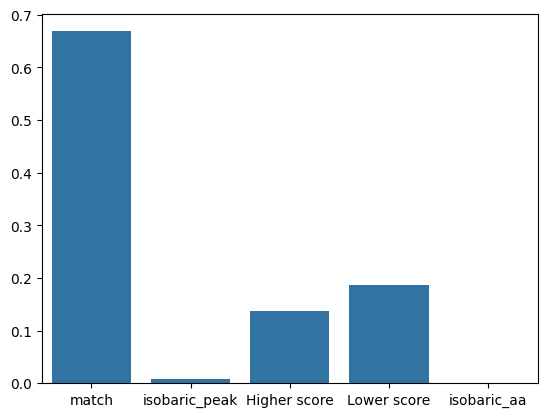

In [240]:
barplot = sns.barplot(pd.Series(match_types).apply(lambda x: x/pd.Series(match_types).sum()))

In [247]:
total_psms = pd.Series(match_types).sum()

<Axes: >

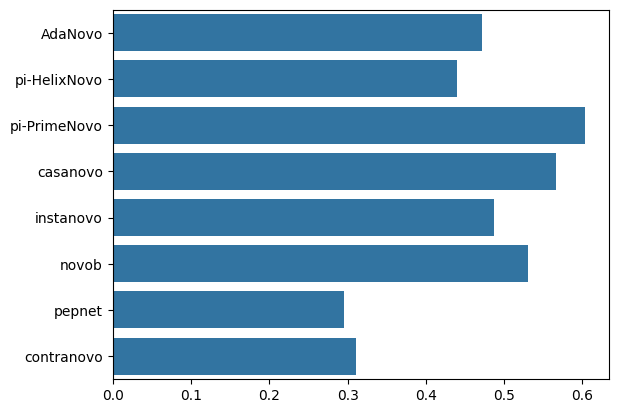

In [250]:
sns.barplot(pd.Series(selected)/total_psms, orient='h')

# 3. Acquire feature table for the set of selected predictions

The features should be extracted from the ground-truth. These features serve as spectrum descriptors in both a qualitative and quantitative sense.

In [161]:
spectrum_ids = {}

for run_name, run in runs.items():
    spectrum_ids[run_name] = {}
    for spec_id, spectrum in run.spectra.items():
        engine = spectrum.psm_candidates[0].engine_name
        try:
            spectrum_ids[run_name][engine].append(spec_id)
        except:
            spectrum_ids[run_name][engine] = [spec_id] 

In [162]:
feature_table = {
    'run': [],
    'spectrum_id': [],
    'best_match_type': [],
    'engines': [],
    'score_ms2rescore': []
}
for run_name, run in runs.items():
    for spec_id, spectrum in run.spectra.items():
        feature_table['run'].append(run_name)
        feature_table['spectrum_id'].append(spec_id)
        feature_table['best_match_type'].append(spectrum.properties['error_type'])
        feature_table['engines'].append(spectrum.properties['denovo_selection'])
        feature_table['score_ms2rescore'].append(spectrum.psm_gt.scores.get_score('score_ms2rescore'))

feature_df = pd.DataFrame(feature_table)

In [170]:
def merge_features(metadata, root_features, feature_names):
    feature_tables_gt = []
    for run_name in runs.keys():
        p = os.path.join(
            root_features,
            run_name,
            'features',
            'ground_truth.parquet'
        )
        f = pd.DataFrame(load_features(p)).T.reset_index()
        f['run'] = run_name
        f = f.rename(columns={'index': 'spectrum_id'})
        feature_tables_gt.append(f)

    features_gt_df = pd.concat(feature_tables_gt, ignore_index=True)
    features = features_gt_df[1].apply(
        lambda x: {k:v for k, v in x.items() if k in feature_names}
    )
    _ = features_gt_df.pop(1)
    features = pd.concat([features_gt_df, pd.DataFrame(features)], axis=1)
    features = pd.concat([
        features[
            ['run',
            'spectrum_id']
        ],
        pd.DataFrame(
            features[1].tolist()
        )
    ], axis=1)

    metadata = metadata.merge(
        features,
        on=['run', 'spectrum_id']
    )
    return metadata


In [171]:
feature_names_1 = [
    'charge_n',
    'ppm_precursor',
    'delta_next',
    'peptide_len',
    'isotope_error',
    'explained_all_pct',
    'explained_y_pct',
    'explained_b_pct',
    'hyperscore',
    'rt_diff_best',
    'cos'
]

feature_names_2 = [
    'missing_frag_sites',
    'missing_frag_pct'
]

In [172]:
root_path_1 = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'
root_path_2 = '/public/compomics3/Sam/PXD028735/QExactive/peptide_evidence_gt'

df = merge_features(
    metadata=feature_df,
    root_features=root_path_1,
    feature_names=feature_names_1
)
df = merge_features(
    metadata=df,
    root_features=root_path_2,
    feature_names=feature_names_2
)

# 4. Plot the figures

## 4.1. Missing fragmentation

In [179]:
def annotate_stacked_histplot(ax):
    # Get the bars' heights
    patches = ax.patches

    # Grouping bars by bins
    heights_by_bin = {}

    # Loop through each patch and store heights by bin
    for patch in patches:
        # The bin location is the x-coordinate of the patch
        bin_location = patch.get_x()
        
        # Store height based on bin location
        if bin_location not in heights_by_bin:
            heights_by_bin[bin_location] = []
        heights_by_bin[bin_location].append(patch.get_height())

    # Annotate percentages
    for bin_location, heights in heights_by_bin.items():
        total_height = sum(heights)
        
        # Calculate percentage and annotate each stack if greater than 5%
        cumulative_height = 0
        for height in heights:
            percentage = (height / total_height) * 100
            
            if percentage > 5:
                # Get the center x-coordinate of the patch
                x = bin_location + 0.25  # Adjust based on binwidth
                
                # Annotate the center of each bar in the stack
                y = cumulative_height + height / 2  # Midpoint of the bar
                
                # Add annotation to the plot
                ax.text(x, y, f'{percentage:.0f}%', ha='center', va='center', color='black', fontsize=8)
            
            # Update cumulative height for stacking annotations
            cumulative_height += height

hue_order = [
    'match',
    'isobaric_peak',
    'Higher score',
    'Lower score',
    'isobaric_aa'
]

/tmp/ipykernel_927907/2764360446.py:25: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (height / total_height) * 100


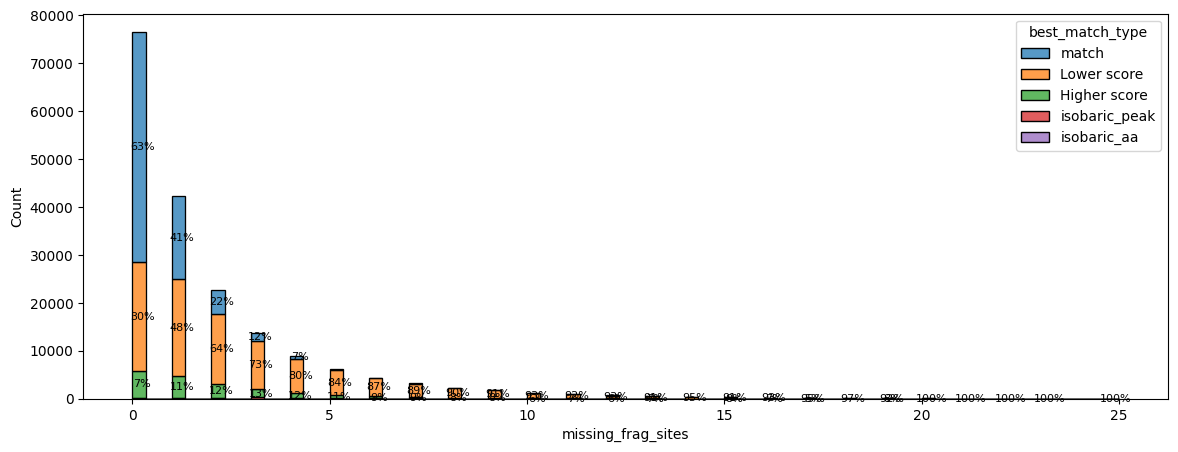

In [120]:
plt.figure(figsize=(14,5))
ax=sns.histplot(
    df,
    x='missing_frag_sites',
    hue='best_match_type',
    multiple='stack',
    binwidth=.333
)

annotate_stacked_histplot(ax)

above: missing fragment sites is for all evidence types (a to z ions and neutral losses)

Below: only for b-y evidence

/tmp/ipykernel_927907/152647550.py:25: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (height / total_height) * 100


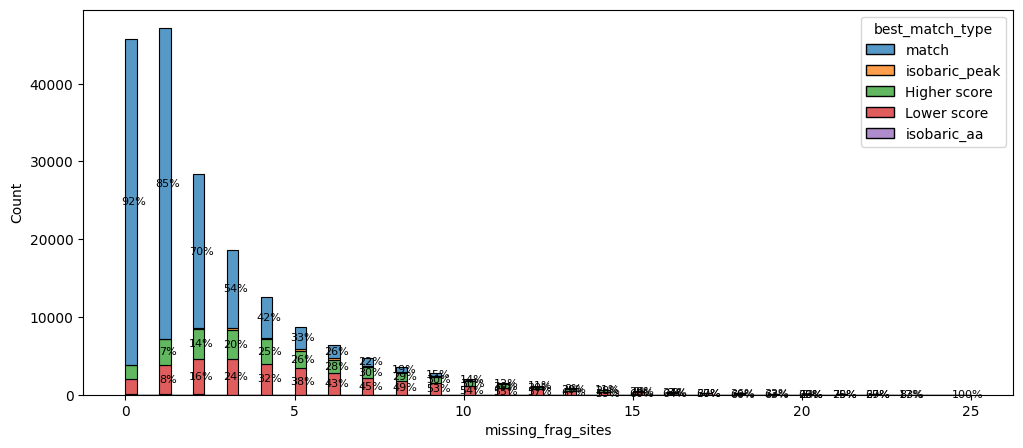

In [288]:
plt.figure(figsize=(12,5))
ax=sns.histplot(
    df,
    x='missing_frag_sites',
    hue='best_match_type',
    multiple='stack',
    binwidth=.333,
    hue_order=hue_order
)

annotate_stacked_histplot(ax)

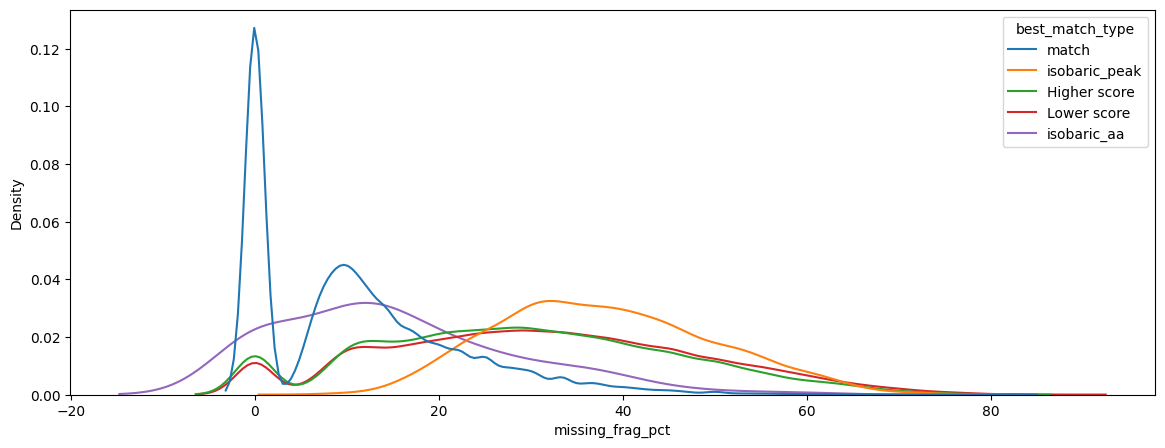

In [181]:
plt.figure(figsize=(14,5))
ax=sns.kdeplot(
    df,
    x='missing_frag_pct',
    hue='best_match_type',
    hue_order=hue_order,
    common_norm=False
)

## 4.2. Explained intensity

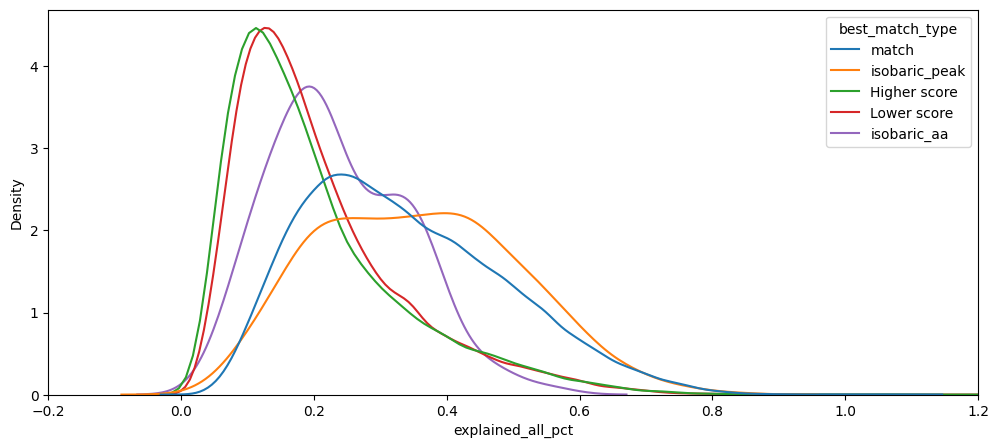

In [289]:
plt.figure(figsize=(12,5))
plt.xlim((-0.2,1.2))
ax=sns.kdeplot(
    df,
    x='explained_all_pct',
    hue='best_match_type',
    hue_order=hue_order,
    common_norm=False
)

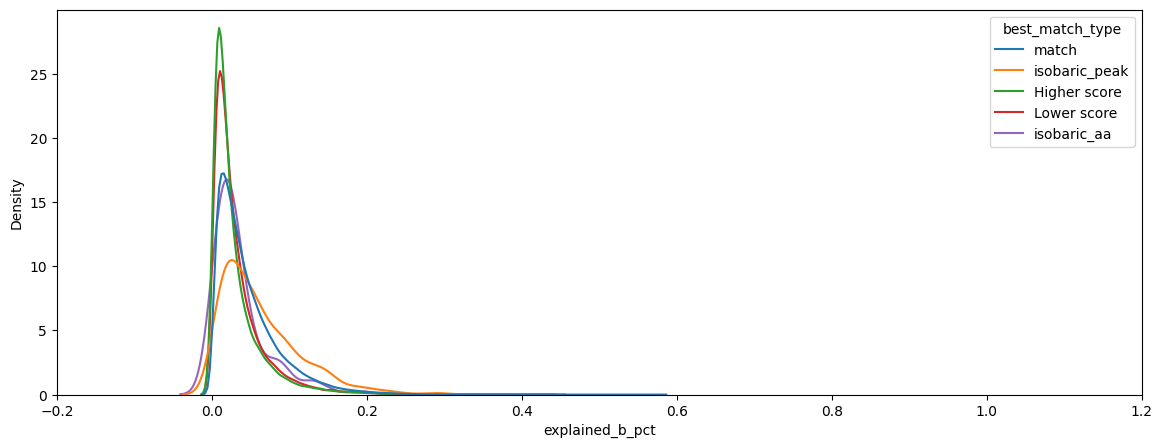

In [275]:
plt.figure(figsize=(14,5))
plt.xlim((-0.2,1.2))
ax=sns.kdeplot(
    df,
    x='explained_b_pct',
    hue='best_match_type',
    hue_order=hue_order,
    common_norm=False
)

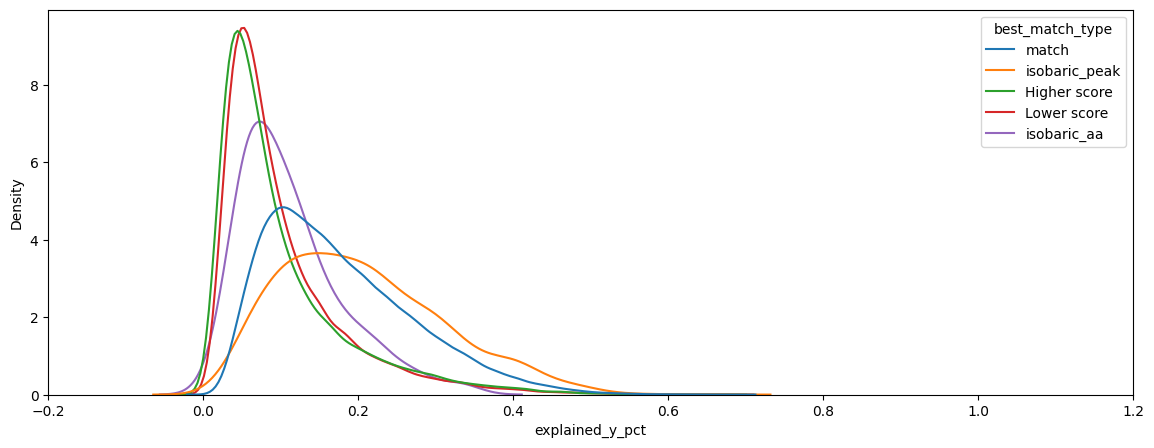

In [276]:
plt.figure(figsize=(14,5))
plt.xlim((-0.2,1.2))
ax=sns.kdeplot(
    df,
    x='explained_y_pct',
    hue='best_match_type',
    hue_order=hue_order,
    common_norm=False
)

## 4.3. Length of the peptide

/tmp/ipykernel_927907/152647550.py:25: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (height / total_height) * 100


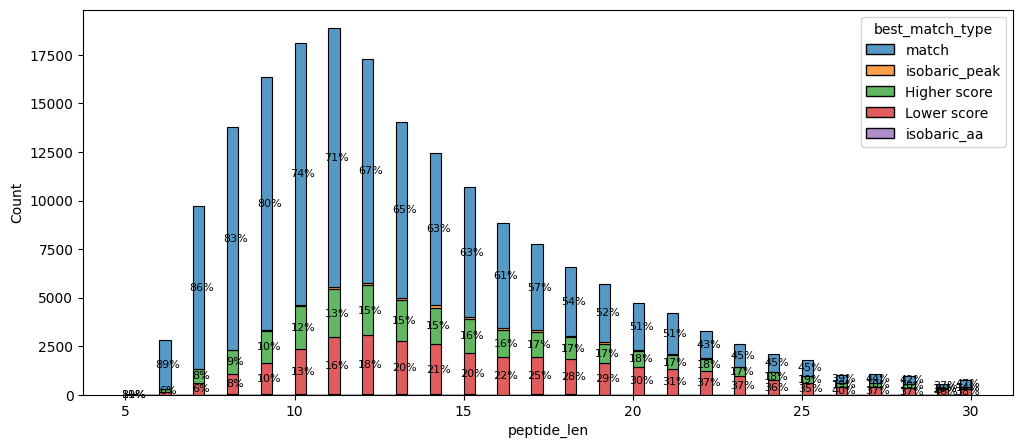

In [290]:
plt.figure(figsize=(12,5))
ax=sns.histplot(
    df,
    x='peptide_len',
    hue='best_match_type',
    hue_order=hue_order,
    multiple='stack',
    binwidth=.333
)

annotate_stacked_histplot(ax)

## 4.4. Charge state

/tmp/ipykernel_927907/152647550.py:25: RuntimeWarning: invalid value encountered in scalar divide
  percentage = (height / total_height) * 100


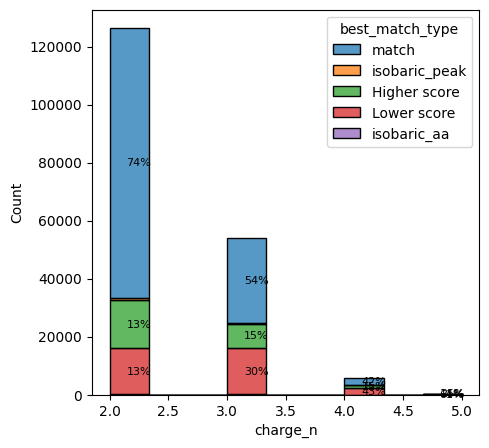

In [292]:
plt.figure(figsize=(5,5))
ax=sns.histplot(
    df,
    x='charge_n',
    hue='best_match_type',
    hue_order=hue_order,
    multiple='stack',
    binwidth=.333
)

annotate_stacked_histplot(ax)

## 4.5. hyperscore

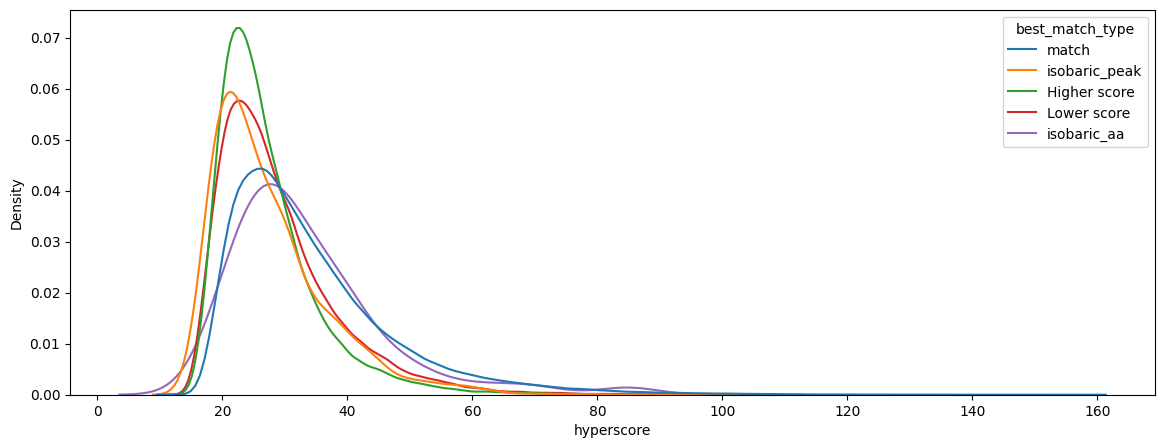

In [185]:
plt.figure(figsize=(14,5))
ax=sns.kdeplot(
    df,
    x='hyperscore',
    hue='best_match_type',
    hue_order=hue_order,
    common_norm=False
)

## 4.6 ms2rescore

([<matplotlib.axis.XTick at 0x7fd9c7c8b850>,
 [Text(0, 0, 'E. coli'),
  Text(1, 0, 'Human'),
  Text(2, 0, 'Mix'),
  Text(3, 0, 'Yeast')])

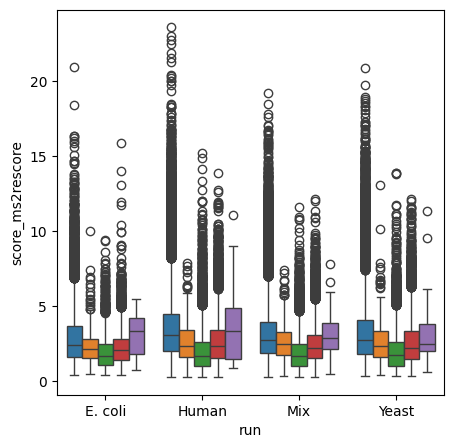

In [293]:
plt.figure(figsize=(5,5))
ax=sns.boxplot(
    df,
    x='run',
    y='score_ms2rescore',
    hue='best_match_type',
    hue_order=hue_order,
    # common_norm=False,
    legend=False
)
plt.xticks([0,1,2,3], ['E. coli', 'Human', 'Mix', 'Yeast'])

## 5. Correlation peptide length and missing fragment sites

SignificanceResult(statistic=0.6733766578231599, pvalue=0.0)

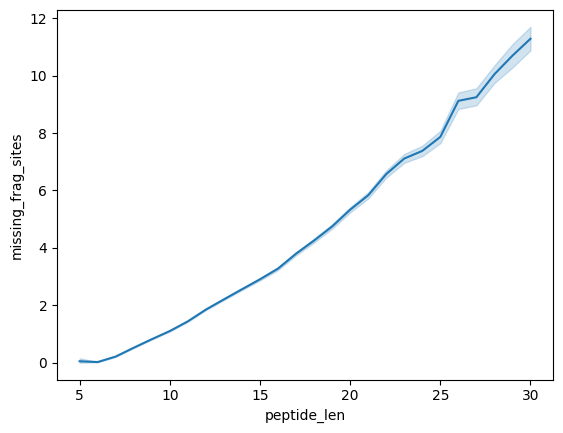

In [203]:
from scipy.stats import spearmanr

sns.lineplot(
    df,
    x='peptide_len',
    y='missing_frag_sites'
)
spearmanr(
    a=df['peptide_len'],
    b=df['missing_frag_sites']
)

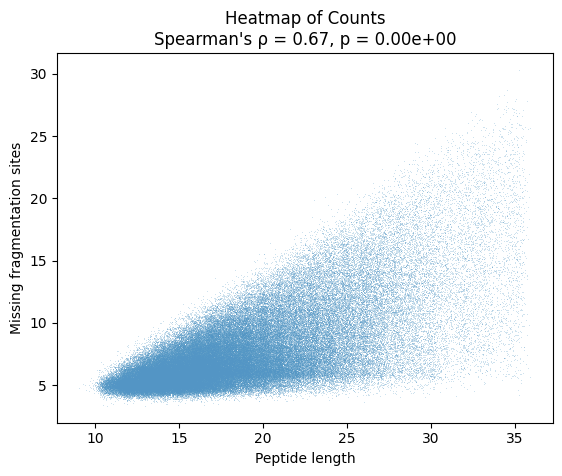

In [235]:
def jitter(values,j):
    return values + np.random.normal(j,0.4,values.shape)

rho, p_value = spearmanr(
    a=df['peptide_len'],
    b=df['missing_frag_sites']
)

sns.scatterplot(x = jitter(df['peptide_len'],5), 
                y = jitter(df['missing_frag_sites'],5),
                s=.5,alpha=0.3)

plt.title(f"Heatmap of Counts\nSpearman's ρ = {rho:.2f}, p = {p_value:.2e}")
plt.xlabel("Peptide length")
plt.ylabel("Missing fragmentation sites")
plt.show()

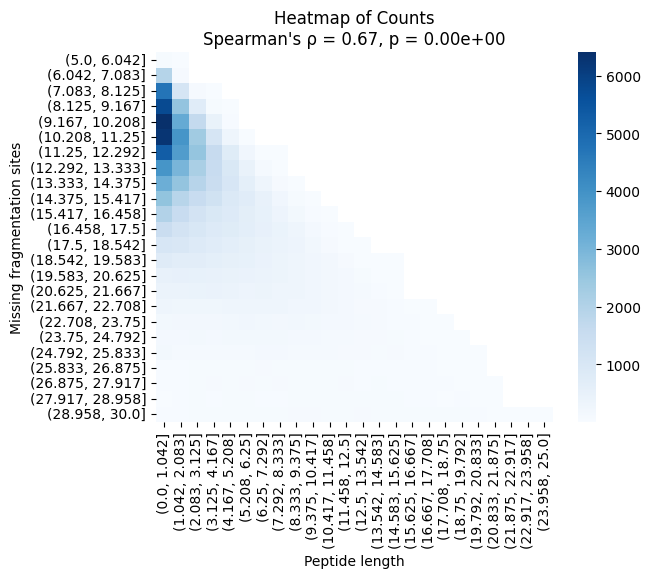

In [209]:
# Bin the data
rho, p_value = spearmanr(
    a=df['peptide_len'],
    b=df['missing_frag_sites']
)

variable_1 = df['peptide_len'].to_numpy()
variable_2 = df['missing_frag_sites'].to_numpy()

bins_x = np.linspace(min(variable_1), max(variable_1), int(max(variable_1)-min(variable_1)))
bins_y = np.linspace(min(variable_2), max(variable_2), int(max(variable_2)-min(variable_2)))

heatmap_data = pd.DataFrame({
    'Variable 1': pd.cut(variable_1, bins=bins_x),
    'Variable 2': pd.cut(variable_2, bins=bins_y)
}).value_counts().unstack()

sns.heatmap(heatmap_data, cmap="Blues")
plt.title(f"Heatmap of Counts\nSpearman's ρ = {rho:.2f}, p = {p_value:.2e}")
plt.xlabel("Peptide length")
plt.ylabel("Missing fragmentation sites")
plt.show()

# 6. Investigation false predictions without missing fragmentation sites

In [273]:
ffe = df[
    (df['missing_frag_sites']==0) &
    (df['best_match_type'] == 'Higher score')
]

ffe['n_engines'] = ffe.apply(lambda x: len(x['engines']), axis=1)

In [303]:
from nltk import edit_distance

mapper = {
    "[+25.980265]-": "b",
    "[Formula:H-2C1O1]-": 'b',
    "[UNIMOD:1]-": "a",
    "[UNIMOD:5]-": "d",
    "[UNIMOD:385]-": "e",
    "Q[UNIMOD:7]": "q",
    "N[UNIMOD:7]": "n",
    "C[UNIMOD:4]": "c",
    "M[UNIMOD:35]": 'm',
    "S[UNIMOD:21]": 's',
    "T[UNIMOD:21]": 't',
    "Y[UNIMOD:21]": 'y',
    "L": "I"
}
def peptidoform_to_lstring(peptidoform, mapper):
    if isinstance(peptidoform, Peptidoform):
        new_peptidoform = peptidoform.proforma
    else:
        new_peptidoform = peptidoform
    for p, l in mapper.items():
        new_peptidoform = new_peptidoform.replace(p, l)
    return new_peptidoform.split('/')[0]

dameraus = []
for i, row in ffe[['run', 'spectrum_id']].iterrows():
    spectrum = runs[row['run']].get_spectrum(row['spectrum_id'])

    pep_dn = peptidoform_to_lstring(spectrum.top_hit.peptidoform, mapper)
    pep_gt = peptidoform_to_lstring(spectrum.psm_gt.peptidoform, mapper)
    damerau_L = edit_distance(
        s1=pep_dn,
        s2=pep_gt,
        transpositions=True
    )
    dameraus.append(damerau_L / max(len(pep_gt), len(pep_dn)))

<Axes: ylabel='Count'>

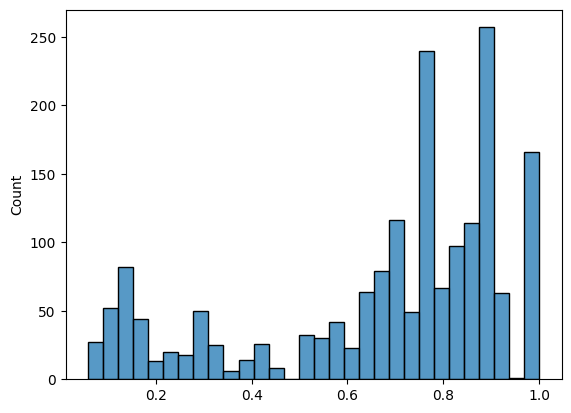

In [306]:
sns.histplot(pd.Series(dameraus), bins=30)

Spectrum ID: controllerType=0 controllerNumber=1 scan=38369
Ground-truth: TSLMIR/2 ({'peptide': {'sage': 1.0651891231536865, 'score_ms2rescore': 1.0651891231536865}, 'aa': {}})
Candidates:
	QSFVLK/2 ({'peptide': {'AdaNovo': 0.9941249489784241, 'score_ms2rescore': 1.5147546621510772}, 'aa': {'AdaNovo': (0.98991, 0.99611, 0.98724, 0.99705, 0.99706, 0.99446)}})
	QSFVLK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 1.5147546621510772}, 'aa': {}})
	QSFVLK/2 ({'peptide': {'pi-PrimeNovo': 0.9988038539886475, 'score_ms2rescore': 1.5147546621510772}, 'aa': {}})
	QSFVLK/2 ({'peptide': {'casanovo': 0.9816778898239136, 'score_ms2rescore': 1.5147546621510772}, 'aa': {'casanovo': (0.97114, 0.98645, 0.97093, 0.9859, 0.98664, 0.98607)}})
	QSFVLK/2 ({'peptide': {'instanovo': -0.007353207096457481, 'score_ms2rescore': 1.5147546621510772}, 'aa': {}})
	QSFVLK/2 ({'peptide': {'contranovo': 0.9990362524986267, 'score_ms2rescore': 1.5147546621510772}, 'aa': {'contranovo': (0.99998, 0.99999, 0.9999

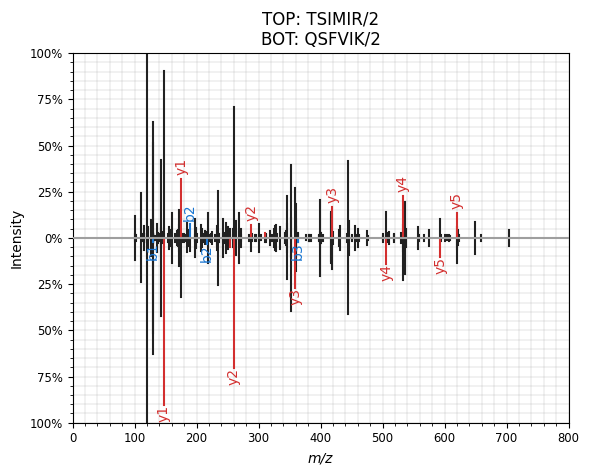

Spectrum ID: controllerType=0 controllerNumber=1 scan=46397
Ground-truth: ADIALIK/2 ({'peptide': {'sage': 0.657707154750824, 'score_ms2rescore': 0.657707154750824}, 'aa': {}})
Candidates:
	ADALLLK/2 ({'peptide': {'AdaNovo': 0.9968217611312866, 'score_ms2rescore': 2.0268188629712154}, 'aa': {'AdaNovo': (0.99803, 0.99832, 0.99808, 0.99754, 0.99834, 0.98745, 0.99841)}})
	ADALLLK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 2.0268188629712154}, 'aa': {}})
	ADALLLK/2 ({'peptide': {'pi-PrimeNovo': 0.9996284246444702, 'score_ms2rescore': 2.0268188629712154}, 'aa': {}})
	ADALLLK/2 ({'peptide': {'casanovo': 0.9862414002418518, 'score_ms2rescore': 2.0268188629712154}, 'aa': {'casanovo': (0.98016, 0.98881, 0.98617, 0.98865, 0.98849, 0.98226, 0.98782)}})
	ADALLLK/2 ({'peptide': {'instanovo': -0.2606421709060669, 'score_ms2rescore': 2.0268188629712154}, 'aa': {}})
	ADALLLK/2 ({'peptide': {'contranovo': 0.9995467662811279, 'score_ms2rescore': 2.0268188629712154}, 'aa': {'contranovo': (0.

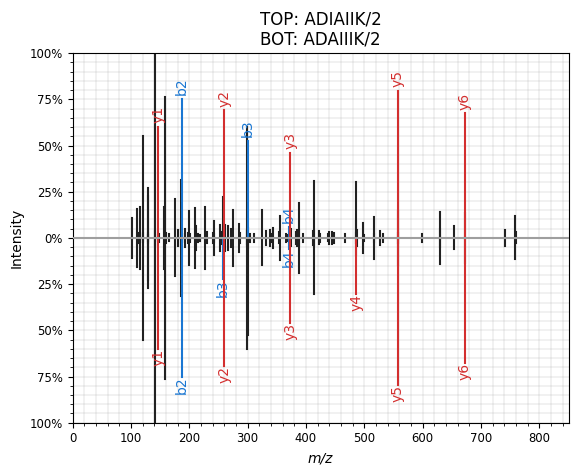

Spectrum ID: controllerType=0 controllerNumber=1 scan=29053
Ground-truth: LVGQVVGAK/2 ({'peptide': {'sage': 0.8432453870773315, 'score_ms2rescore': 0.8432453870773315}, 'aa': {}})
Candidates:
	<AV>AALEAAR/2 ({'peptide': {'AdaNovo': 0.9646424055099487, 'score_ms2rescore': 2.477408767739796}, 'aa': {'AdaNovo': (0.81414, 0.98026, 0.98227, 0.9782, 0.98209, 0.98217, 0.9823, 0.98036, 0.98232)}})
	<AV>AALEAAR/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 2.477408767739796}, 'aa': {}})
	<AV>AALEAAR/2 ({'peptide': {'pi-PrimeNovo': 0.9804288148880005, 'score_ms2rescore': 2.477408767739796}, 'aa': {}})
	<AV>AALEAAR/2 ({'peptide': {'casanovo': 0.9822357296943665, 'score_ms2rescore': 2.477408767739796}, 'aa': {'casanovo': (0.96084, 0.98782, 0.98561, 0.97184, 0.98666, 0.98742, 0.98611, 0.98249, 0.98698)}})
	<AV>AALEAAR/2 ({'peptide': {'instanovo': -0.03870715573430061, 'score_ms2rescore': 2.477408767739796}, 'aa': {}})
	<AV>AALEAAR/2 ({'peptide': {'contranovo': 0.9969696998

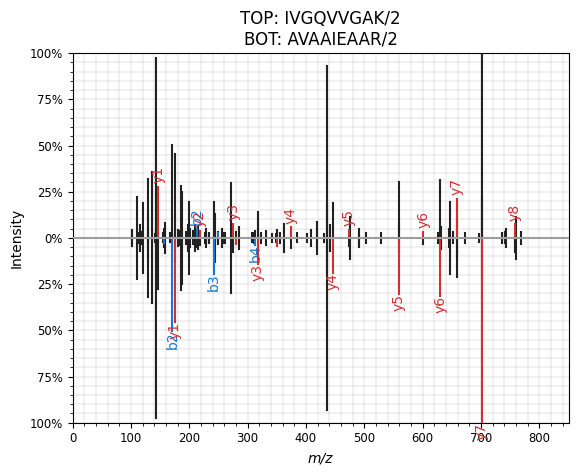

Spectrum ID: controllerType=0 controllerNumber=1 scan=44060
Ground-truth: LNSNLNLVAR/2 ({'peptide': {'sage': 2.1669228076934814, 'score_ms2rescore': 2.1669228076934814}, 'aa': {}})
Candidates:
	LSPLAEQLDK/2 ({'peptide': {'AdaNovo': 0.9936498403549194, 'score_ms2rescore': 3.5126276767270768}, 'aa': {'AdaNovo': (0.96696, 0.99404, 0.99679, 0.99656, 0.9956, 0.99682, 0.99682, 0.99682, 0.99608, 0.99682)}})
	LSPLAEQLDK/2 ({'peptide': {'pi-HelixNovo': 0.9900000095367432, 'score_ms2rescore': 3.5126276767270768}, 'aa': {}})
	LSPLAEQLDK/2 ({'peptide': {'pi-PrimeNovo': 0.9988502264022827, 'score_ms2rescore': 3.5126276767270768}, 'aa': {}})
	LSPLAEQLDK/2 ({'peptide': {'casanovo': 0.9883361458778381, 'score_ms2rescore': 3.5126276767270768}, 'aa': {'casanovo': (0.98974, 0.98218, 0.98931, 0.99026, 0.98262, 0.98914, 0.98967, 0.98964, 0.99021, 0.98968)}})
	LSPLAEQLDK/2 ({'peptide': {'instanovo': -0.01804855465888977, 'score_ms2rescore': 3.5126276767270768}, 'aa': {}})
	LSPLAEQLDK/2 ({'peptide': {'contra

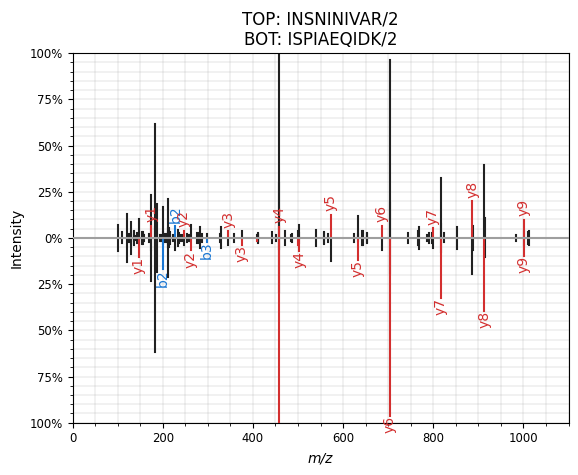

Spectrum ID: controllerType=0 controllerNumber=1 scan=34009
Ground-truth: FLQVM[UNIMOD:35]QK/2 ({'peptide': {'sage': 1.6801862716674805, 'score_ms2rescore': 1.6801862716674805}, 'aa': {}})
Candidates:
	LNVLNGGSH/2 ({'peptide': {'AdaNovo': 0.998431384563446, 'score_ms2rescore': 2.0101567893684535}, 'aa': {'AdaNovo': (0.99614, 0.99921, 0.9979, 0.99922, 0.99678, 0.99921, 0.99922, 0.99822, 0.99922)}})
	LNVLNGGSH/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 2.0101567893684535}, 'aa': {}})
	LNVLNGGSH/2 ({'peptide': {'pi-PrimeNovo': 0.9999877214431763, 'score_ms2rescore': 2.0101567893684535}, 'aa': {}})
	LNVLNGGSH/2 ({'peptide': {'casanovo': 0.9850382804870605, 'score_ms2rescore': 2.0101567893684535}, 'aa': {'casanovo': (0.96071, 0.98681, 0.98801, 0.9881, 0.98841, 0.98786, 0.98861, 0.98722, 0.98669)}})
	LNVLNGGSH/2 ({'peptide': {'instanovo': -0.059698157012462616, 'score_ms2rescore': 2.0101567893684535}, 'aa': {}})
	LNVLNGGSH/2 ({'peptide': {'contranovo': 0.9997686147689819, 'scor

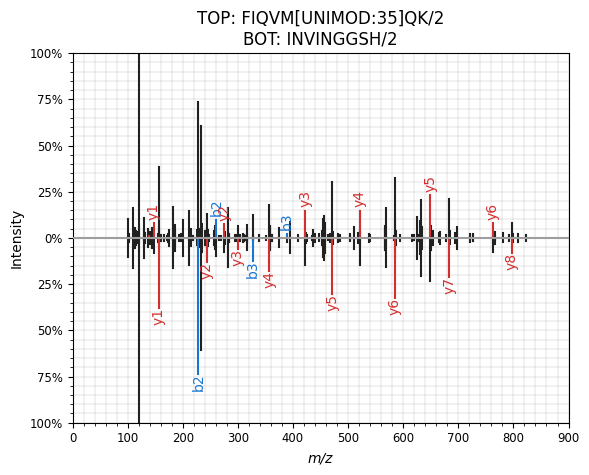

Spectrum ID: controllerType=0 controllerNumber=1 scan=40395
Ground-truth: ALAYDAIK/2 ({'peptide': {'sage': 1.0641100406646729, 'score_ms2rescore': 1.0641100406646729}, 'aa': {}})
Candidates:
	ALAYGLEK/2 ({'peptide': {'AdaNovo': 0.9993049502372742, 'score_ms2rescore': 2.325097571478287}, 'aa': {'AdaNovo': (0.99959, 0.99668, 0.99961, 0.99963, 0.99965, 0.99965, 0.99963, 0.99965)}})
	ALAYGLEK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 2.325097571478287}, 'aa': {}})
	ALAYGLEK/2 ({'peptide': {'pi-PrimeNovo': 0.9886326193809509, 'score_ms2rescore': 2.325097571478287}, 'aa': {}})
	ALAYGLEK/2 ({'peptide': {'casanovo': 0.9872239232063293, 'score_ms2rescore': 2.325097571478287}, 'aa': {'casanovo': (0.98888, 0.97431, 0.98858, 0.98923, 0.98827, 0.98892, 0.98925, 0.98872)}})
	ALAYGLEK/2 ({'peptide': {'instanovo': -0.0038982597179710865, 'score_ms2rescore': 2.325097571478287}, 'aa': {}})
	ALAYGLEK/2 ({'peptide': {'contranovo': 0.9963493943214417, 'score_ms2rescore': 2.325097571478287}, 

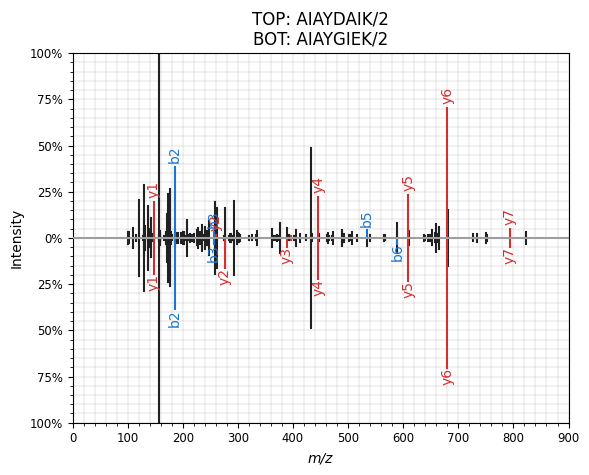

Spectrum ID: controllerType=0 controllerNumber=1 scan=40344
Ground-truth: LFHGALVDGR/3 ({'peptide': {'sage': 1.6433608531951904, 'score_ms2rescore': 1.6433608531951904}, 'aa': {}})
Candidates:
	<NL>QHLLYGK/3 ({'peptide': {'AdaNovo': 0.9969376921653748, 'score_ms2rescore': 1.7234271833786974}, 'aa': {'AdaNovo': (0.99635, 0.99778, 0.99846, 0.9983, 0.99846, 0.99009, 0.99559, 0.99812, 0.99775)}})
	<NL>QHLLYGK/3 ({'peptide': {'pi-HelixNovo': 0.9900000095367432, 'score_ms2rescore': 1.7234271833786974}, 'aa': {}})
	<NL>QHLLYGK/3 ({'peptide': {'pi-PrimeNovo': 0.9751833081245422, 'score_ms2rescore': 1.7234271833786974}, 'aa': {}})
	<NL>QHLLYGK/3 ({'peptide': {'casanovo': 0.9892449378967285, 'score_ms2rescore': 1.7234271833786974}, 'aa': {'casanovo': (0.99005, 0.99055, 0.99012, 0.98903, 0.99042, 0.98941, 0.98913, 0.99059, 0.98353)}})
	<NL>QHLLYGK/3 ({'peptide': {'instanovo': -0.03592619672417641, 'score_ms2rescore': 1.7234271833786974}, 'aa': {}})
	<NL>QHLLYGK/3 ({'peptide': {'contranovo': 0.999

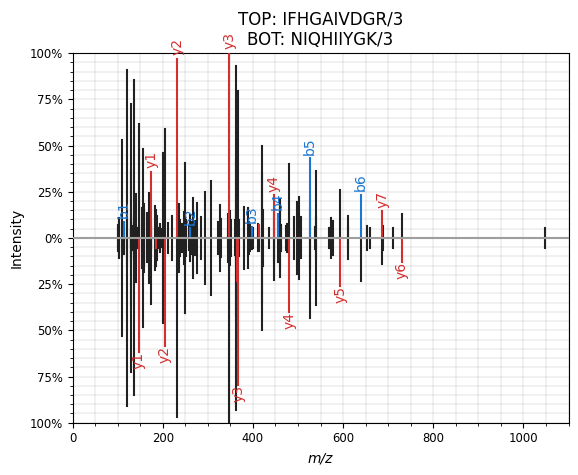

Spectrum ID: controllerType=0 controllerNumber=1 scan=53487
Ground-truth: EALLDSLK/2 ({'peptide': {'sage': 0.9545664191246033, 'score_ms2rescore': 0.9545664191246033}, 'aa': {}})
Candidates:
	VLGNLFAR/2 ({'peptide': {'AdaNovo': 0.9948743581771851, 'score_ms2rescore': 2.216203550451895}, 'aa': {'AdaNovo': (0.9753, 0.99662, 0.99744, 0.99742, 0.99735, 0.99744, 0.99744, 0.99744)}})
	VLGNLFAR/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 2.216203550451895}, 'aa': {}})
	VLGNLFAR/2 ({'peptide': {'pi-PrimeNovo': 0.9999860525131226, 'score_ms2rescore': 2.216203550451895}, 'aa': {}})
	VLGNLFAR/2 ({'peptide': {'casanovo': 0.9879370331764221, 'score_ms2rescore': 2.216203550451895}, 'aa': {'casanovo': (0.98199, 0.98498, 0.98914, 0.98908, 0.98931, 0.98946, 0.98921, 0.9887)}})
	VLGNLFAR/2 ({'peptide': {'instanovo': -0.1435515433549881, 'score_ms2rescore': 2.216203550451895}, 'aa': {}})
	VLGNLFAR/2 ({'peptide': {'contranovo': 0.9999064803123474, 'score_ms2rescore': 2.216203550451895}, 'aa':

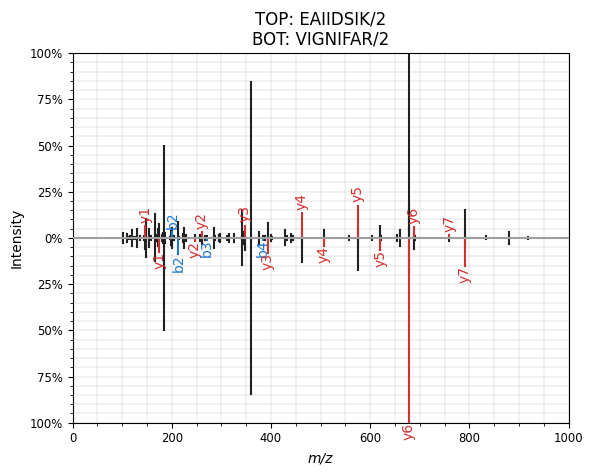

Spectrum ID: controllerType=0 controllerNumber=1 scan=46975
Ground-truth: ADIALIK/2 ({'peptide': {'sage': 1.0337531566619873, 'score_ms2rescore': 1.0337531566619873}, 'aa': {}})
Candidates:
	ADALLLK/2 ({'peptide': {'AdaNovo': 0.9908103942871094, 'score_ms2rescore': 2.3518349991319667}, 'aa': {'AdaNovo': (0.99408, 0.99312, 0.99314, 0.9898, 0.99505, 0.97051, 0.99538)}})
	ADALLLK/2 ({'peptide': {'pi-HelixNovo': 0.9900000095367432, 'score_ms2rescore': 2.3518349991319667}, 'aa': {}})
	ADALLLK/2 ({'peptide': {'pi-PrimeNovo': 0.9878437519073486, 'score_ms2rescore': 2.3518349991319667}, 'aa': {}})
	ADALLLK/2 ({'peptide': {'casanovo': 0.9677338600158691, 'score_ms2rescore': 2.3518349991319667}, 'aa': {'casanovo': (0.97366, 0.91594, 0.97648, 0.9791, 0.97943, 0.96105, 0.97812)}})
	ADALLLK/2 ({'peptide': {'instanovo': -0.14335569739341736, 'score_ms2rescore': 2.3518349991319667}, 'aa': {}})
	ADALLLK/2 ({'peptide': {'contranovo': 0.9977411031723022, 'score_ms2rescore': 2.3518349991319667}, 'aa': {'

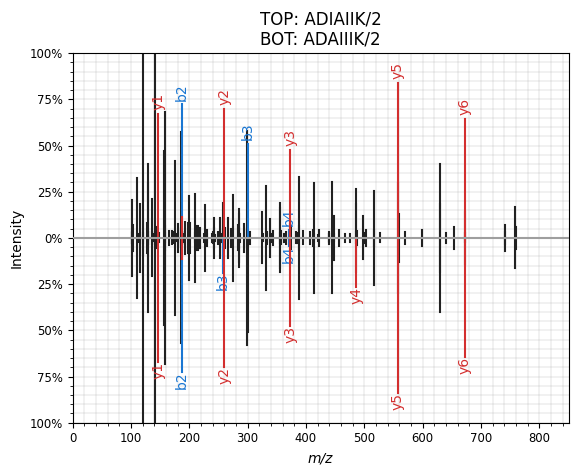

Spectrum ID: controllerType=0 controllerNumber=1 scan=21871
Ground-truth: NSPLLER/2 ({'peptide': {'sage': 0.6664428114891052, 'score_ms2rescore': 0.6664428114891052}, 'aa': {}})
Candidates:
	SNPLLER/2 ({'peptide': {'AdaNovo': 0.8380141854286194, 'score_ms2rescore': 0.7214777022841901}, 'aa': {'AdaNovo': (0.77747, 0.8803, 0.45421, 0.91864, 0.919, 0.91649, 0.91901)}})
	SNPLLER/2 ({'peptide': {'pi-HelixNovo': 0.8799999952316284, 'score_ms2rescore': 0.7214777022841901}, 'aa': {}})
	SNPLLER/2 ({'peptide': {'pi-PrimeNovo': 0.6834226846694946, 'score_ms2rescore': 0.7214777022841901}, 'aa': {}})
	SNPLLER/2 ({'peptide': {'casanovo': 0.8987539410591125, 'score_ms2rescore': 0.7214777022841901}, 'aa': {'casanovo': (0.79171, 0.90919, 0.93809, 0.94531, 0.94516, 0.77324, 0.94253)}})
	SNPLLER/2 ({'peptide': {'instanovo': -0.2132728546857834, 'score_ms2rescore': 0.7214777022841901}, 'aa': {}})
	SNPLLER/2 ({'peptide': {'contranovo': 0.9908249378204346, 'score_ms2rescore': 0.7214777022841901}, 'aa': {'co

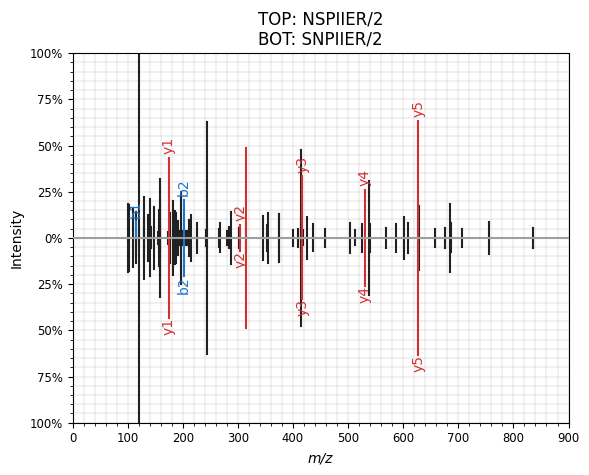

Spectrum ID: controllerType=0 controllerNumber=1 scan=33202
Ground-truth: LHFGLK/2 ({'peptide': {'sage': 1.13495671749115, 'score_ms2rescore': 1.13495671749115}, 'aa': {}})
Candidates:
	LHLFGK/2 ({'peptide': {'AdaNovo': 0.9975451231002808, 'score_ms2rescore': 1.4189422191545846}, 'aa': {'AdaNovo': (0.99875, 0.99712, 0.9928, 0.99798, 0.99864, 0.99877)}})
	LHLFGK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 1.4189422191545846}, 'aa': {}})
	LHLFGK/2 ({'peptide': {'pi-PrimeNovo': 0.9999921321868896, 'score_ms2rescore': 1.4189422191545846}, 'aa': {}})
	LHLFGK/2 ({'peptide': {'casanovo': 0.9897679090499878, 'score_ms2rescore': 1.4189422191545846}, 'aa': {'casanovo': (0.99041, 0.99031, 0.99054, 0.98979, 0.99077, 0.98728)}})
	LHLFGK/2 ({'peptide': {'instanovo': -0.0025700379628688097, 'score_ms2rescore': 1.4189422191545846}, 'aa': {}})
	LHLFGK/2 ({'peptide': {'contranovo': 0.9999797940254211, 'score_ms2rescore': 1.4189422191545846}, 'aa': {'contranovo': (0.99998, 0.99998, 0.99997, 

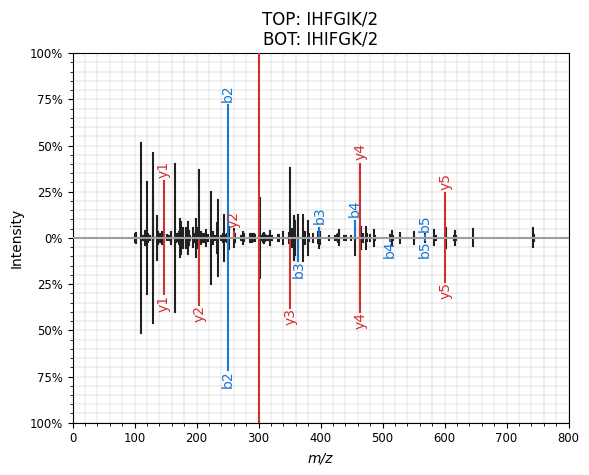

Spectrum ID: controllerType=0 controllerNumber=1 scan=44722
Ground-truth: LLFM[UNIMOD:35]QR/2 ({'peptide': {'sage': 0.8872019648551941, 'score_ms2rescore': 0.8872019648551941}, 'aa': {}})
Candidates:
	TALMNFK/2 ({'peptide': {'AdaNovo': 0.9986017346382141, 'score_ms2rescore': 1.2669901909295194}, 'aa': {'AdaNovo': (0.99594, 0.99874, 0.99795, 0.99924, 0.99911, 0.99925, 0.99928)}})
	TALMNFK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 1.2669901909295194}, 'aa': {}})
	TALMNFK/2 ({'peptide': {'pi-PrimeNovo': 0.9999327659606934, 'score_ms2rescore': 1.2669901909295194}, 'aa': {}})
	TALMNFK/2 ({'peptide': {'casanovo': 0.9908565282821655, 'score_ms2rescore': 1.2669901909295194}, 'aa': {'casanovo': (0.99134, 0.99069, 0.99077, 0.99135, 0.99082, 0.99158, 0.98962)}})
	TALMNFK/2 ({'peptide': {'instanovo': -0.00993130449205637, 'score_ms2rescore': 1.2669901909295194}, 'aa': {}})
	TALMNFK/2 ({'peptide': {'contranovo': 0.9999430775642395, 'score_ms2rescore': 1.2669901909295194}, 'aa': {'con

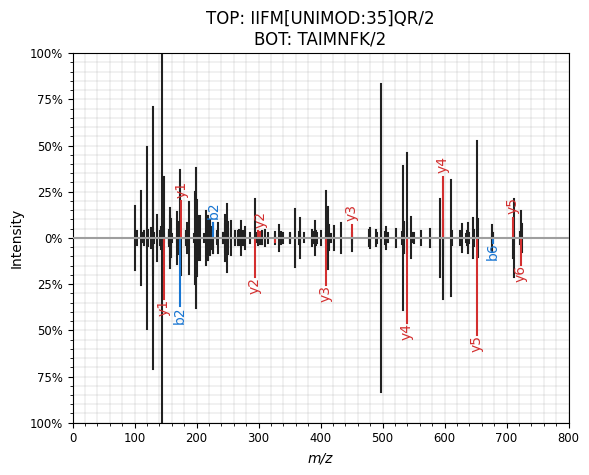

Spectrum ID: controllerType=0 controllerNumber=1 scan=36514
Ground-truth: ITDQLLK/2 ({'peptide': {'sage': 1.2258601188659668, 'score_ms2rescore': 1.2258601188659668}, 'aa': {}})
Candidates:
	LTVEQLK/2 ({'peptide': {'AdaNovo': 0.9901323318481445, 'score_ms2rescore': 1.4334467554977166}, 'aa': {'AdaNovo': (0.99486, 0.96202, 0.98961, 0.99441, 0.99503, 0.99499, 0.99507)}})
	LTVEQLK/2 ({'peptide': {'pi-HelixNovo': 0.9900000095367432, 'score_ms2rescore': 1.4334467554977166}, 'aa': {}})
	LTVEQLK/2 ({'peptide': {'pi-PrimeNovo': 0.99868243932724, 'score_ms2rescore': 1.4334467554977166}, 'aa': {}})
	LTVEQLK/2 ({'peptide': {'casanovo': 0.9880836606025696, 'score_ms2rescore': 1.4334467554977166}, 'aa': {'casanovo': (0.98973, 0.98961, 0.98929, 0.97909, 0.98908, 0.98935, 0.98904)}})
	LTVEQLK/2 ({'peptide': {'instanovo': -0.015108434483408928, 'score_ms2rescore': 1.4334467554977166}, 'aa': {}})
	LTVEQLK/2 ({'peptide': {'contranovo': 0.9980708956718445, 'score_ms2rescore': 1.4334467554977166}, 'aa': {

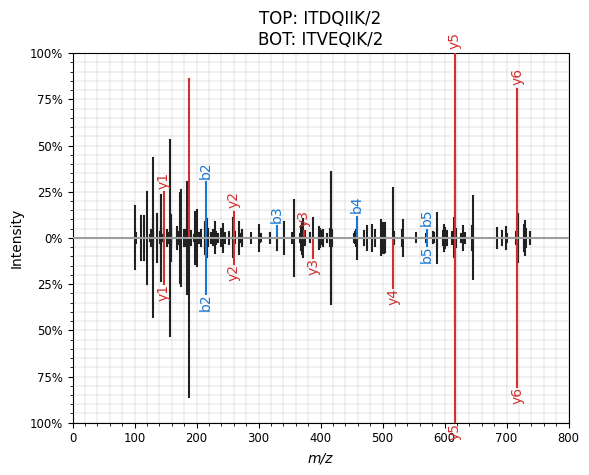

Spectrum ID: controllerType=0 controllerNumber=1 scan=25972
Ground-truth: LM[UNIMOD:35]ATLR/2 ({'peptide': {'sage': 0.8232228755950928, 'score_ms2rescore': 0.8232228755950928}, 'aa': {}})
Candidates:
	FVSQLK/2 ({'peptide': {'AdaNovo': 0.9964125156402588, 'score_ms2rescore': 0.8457029325167095}, 'aa': {'AdaNovo': (0.99693, 0.99752, 0.98764, 0.99821, 0.99818, 0.99821)}})
	FVSQLK/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 0.8457029325167095}, 'aa': {}})
	FVSQLK/2 ({'peptide': {'pi-PrimeNovo': 0.999987006187439, 'score_ms2rescore': 0.8457029325167095}, 'aa': {}})
	FVSQLK/2 ({'peptide': {'casanovo': 0.987981379032135, 'score_ms2rescore': 0.8457029325167095}, 'aa': {'casanovo': (0.98324, 0.98822, 0.98912, 0.98904, 0.98934, 0.98826)}})
	FVSQLK/2 ({'peptide': {'instanovo': -0.005172464996576309, 'score_ms2rescore': 0.8457029325167095}, 'aa': {}})
	FVSQLK/2 ({'peptide': {'contranovo': 0.9999572038650513, 'score_ms2rescore': 0.8457029325167095}, 'aa': {'contranovo': 

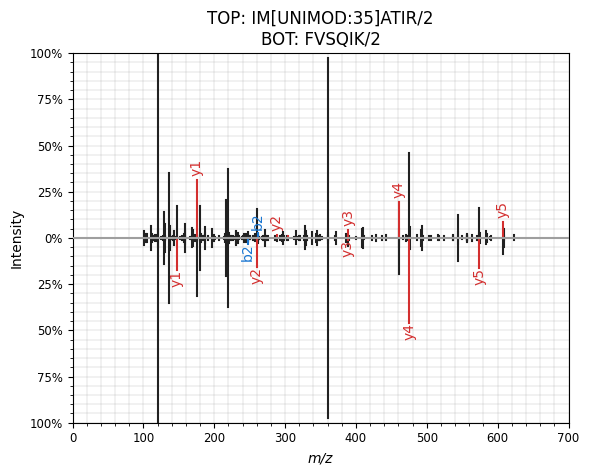

Spectrum ID: controllerType=0 controllerNumber=1 scan=12448
Ground-truth: VEHLAVR/2 ({'peptide': {'sage': 1.096297025680542, 'score_ms2rescore': 1.096297025680542}, 'aa': {}})
Candidates:
	QLSALHR/2 ({'peptide': {'AdaNovo': 0.9884928464889526, 'score_ms2rescore': 3.0344845904572537}, 'aa': {'AdaNovo': (0.9817, 0.963, 0.99403, 0.99415, 0.99424, 0.9942, 0.99237)}})
	QLSALHR/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 3.0344845904572537}, 'aa': {}})
	QLSALHR/2 ({'peptide': {'pi-PrimeNovo': 0.9999743700027466, 'score_ms2rescore': 3.0344845904572537}, 'aa': {}})
	QLSALHR/2 ({'peptide': {'casanovo': 0.9905756115913391, 'score_ms2rescore': 3.0344845904572537}, 'aa': {'casanovo': (0.99133, 0.98886, 0.99037, 0.99201, 0.99046, 0.99043, 0.99069)}})
	QLSALHR/2 ({'peptide': {'instanovo': -0.015493263490498066, 'score_ms2rescore': 3.0344845904572537}, 'aa': {}})
	QLSALHR/2 ({'peptide': {'contranovo': 0.999943733215332, 'score_ms2rescore': 3.0344845904572537}, 'aa': {'contranovo': (0.999

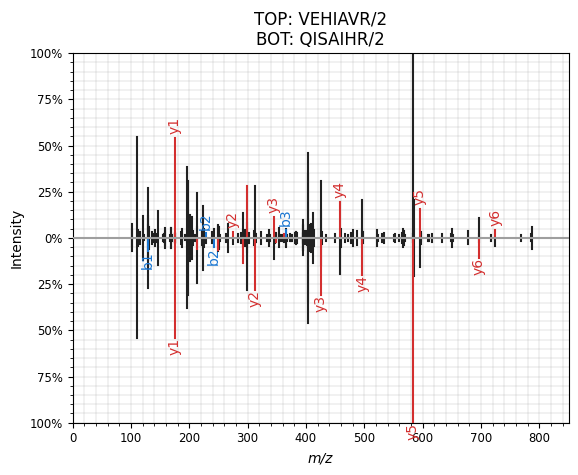

Spectrum ID: controllerType=0 controllerNumber=1 scan=43290
Ground-truth: ITAGILR/2 ({'peptide': {'sage': 0.3550637662410736, 'score_ms2rescore': 0.3550637662410736}, 'aa': {}})
Candidates:
	LQTLLR/2 ({'peptide': {'AdaNovo': 0.996993362903595, 'score_ms2rescore': 1.2136688625375498}, 'aa': {'AdaNovo': (0.99585, 0.99818, 0.99303, 0.99812, 0.99684, 0.99845)}})
	LQTLLR/2 ({'peptide': {'pi-HelixNovo': 0.9700000286102295, 'score_ms2rescore': 1.2136688625375498}, 'aa': {}})
	LQTLLR/2 ({'peptide': {'pi-PrimeNovo': 0.9997645020484924, 'score_ms2rescore': 1.2136688625375498}, 'aa': {}})
	LQTLLR/2 ({'peptide': {'casanovo': 0.9900463819503784, 'score_ms2rescore': 1.2136688625375498}, 'aa': {'casanovo': (0.99009, 0.99058, 0.99033, 0.99101, 0.99063, 0.98745)}})
	LQTLLR/2 ({'peptide': {'instanovo': -0.033329252153635025, 'score_ms2rescore': 1.2136688625375498}, 'aa': {}})
	LQTLLR/2 ({'peptide': {'contranovo': 0.9999437928199768, 'score_ms2rescore': 1.2136688625375498}, 'aa': {'contranovo': (0.99999,

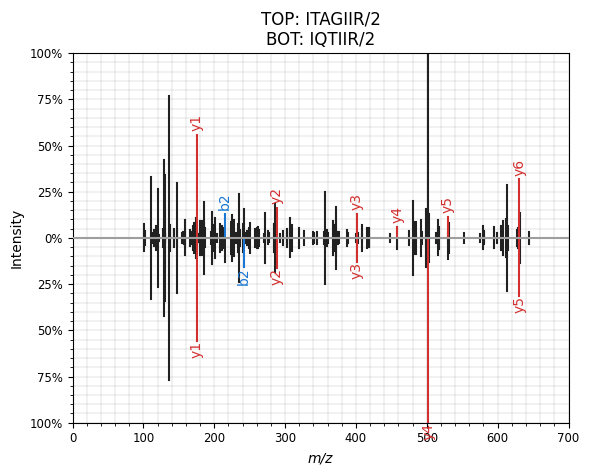

Spectrum ID: controllerType=0 controllerNumber=1 scan=106168
Ground-truth: IIQFIQEQLK/2 ({'peptide': {'sage': 0.985212504863739, 'score_ms2rescore': 0.985212504863739}, 'aa': {}})
Candidates:
	LFQLLQEAGLK/2 ({'peptide': {'AdaNovo': 0.9991231560707092, 'score_ms2rescore': 4.507430033343689}, 'aa': {'AdaNovo': (0.99955, 0.99882, 0.99785, 0.99954, 0.99875, 0.99871, 0.99956, 0.99956, 0.99847, 0.99956, 0.99956)}})
	LFQLLQEAGLK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 4.507430033343689}, 'aa': {}})
	LFQLLQEAGLK/2 ({'peptide': {'pi-PrimeNovo': 0.9999001026153564, 'score_ms2rescore': 4.507430033343689}, 'aa': {}})
	LFQLLQEAGLK/2 ({'peptide': {'casanovo': 0.9892034530639648, 'score_ms2rescore': 4.507430033343689}, 'aa': {'casanovo': (0.98922, 0.9903, 0.98994, 0.99005, 0.98383, 0.98929, 0.9898, 0.98987, 0.98885, 0.98977, 0.98969)}})
	LFQLLQEAGLK/2 ({'peptide': {'instanovo': -0.005460822489112616, 'score_ms2rescore': 4.507430033343689}, 'aa': {}})
	LFQLLQEAGLK/2 ({'peptide': {'con

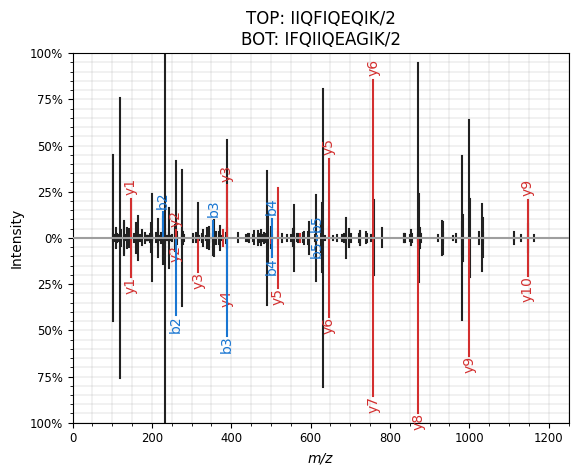

Spectrum ID: controllerType=0 controllerNumber=1 scan=51136
Ground-truth: NSLYDMAR/2 ({'peptide': {'sage': 1.7550816535949707, 'score_ms2rescore': 1.7550816535949707}, 'aa': {}})
Candidates:
	FADENFVK/2 ({'peptide': {'AdaNovo': 0.9957504868507385, 'score_ms2rescore': 1.975515160980059}, 'aa': {'AdaNovo': (0.99251, 0.99777, 0.99771, 0.99595, 0.99769, 0.99694, 0.98743, 0.99788)}})
	FADENFVK/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 1.975515160980059}, 'aa': {}})
	FADENFVK/2 ({'peptide': {'pi-PrimeNovo': 0.9979228377342224, 'score_ms2rescore': 1.975515160980059}, 'aa': {}})
	FADENFVK/2 ({'peptide': {'casanovo': 0.9838823676109314, 'score_ms2rescore': 1.975515160980059}, 'aa': {'casanovo': (0.98679, 0.98764, 0.98748, 0.98817, 0.98342, 0.96017, 0.98659, 0.98758)}})
	FADENFVK/2 ({'peptide': {'instanovo': -0.012205320410430431, 'score_ms2rescore': 1.975515160980059}, 'aa': {}})
	FADENFVK/2 ({'peptide': {'contranovo': 0.9972689747810364, 'score_ms2rescore': 1.9755

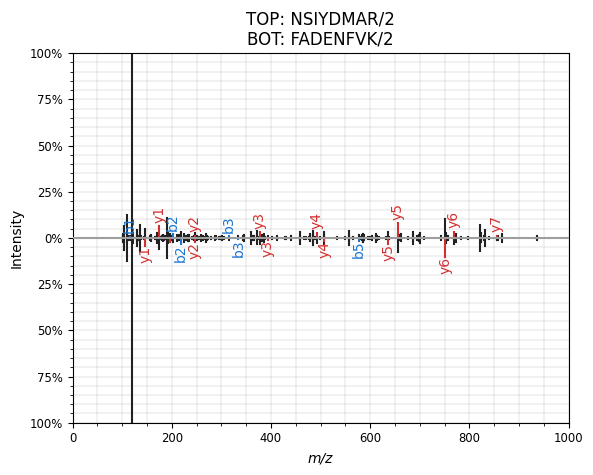

Spectrum ID: controllerType=0 controllerNumber=1 scan=49735
Ground-truth: FSQLYPER/2 ({'peptide': {'sage': 1.6954104900360107, 'score_ms2rescore': 1.6954104900360107}, 'aa': {}})
Candidates:
	LYEEAWTK/2 ({'peptide': {'AdaNovo': 0.987983226776123, 'score_ms2rescore': 1.9889329703930034}, 'aa': {'AdaNovo': (0.99394, 0.94019, 0.99397, 0.9938, 0.99399, 0.99399, 0.99399, 0.99399)}})
	LYEEAWTK/2 ({'peptide': {'pi-HelixNovo': 0.9700000286102295, 'score_ms2rescore': 1.9889329703930034}, 'aa': {}})
	LYEEAWTK/2 ({'peptide': {'pi-PrimeNovo': 0.9973859190940857, 'score_ms2rescore': 1.9889329703930034}, 'aa': {}})
	LYEEAWTK/2 ({'peptide': {'casanovo': 0.9850341081619263, 'score_ms2rescore': 1.9889329703930034}, 'aa': {'casanovo': (0.98816, 0.98066, 0.9874, 0.98737, 0.9847, 0.97666, 0.98745, 0.98542)}})
	LYEEAWTK/2 ({'peptide': {'instanovo': -0.2655852138996124, 'score_ms2rescore': 1.9889329703930034}, 'aa': {}})
	LYEEAWTK/2 ({'peptide': {'contranovo': 0.999413788318634, 'score_ms2rescore': 1.988932

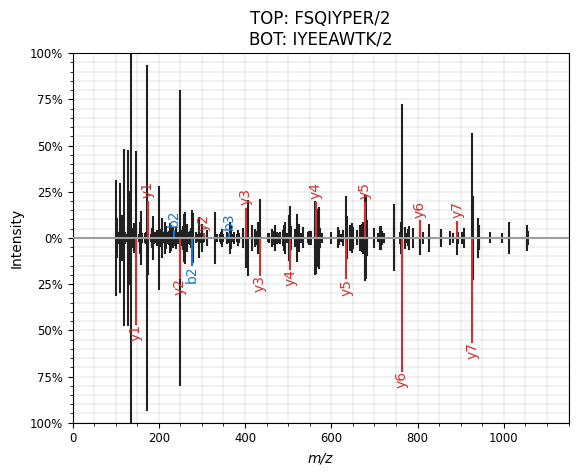

Spectrum ID: controllerType=0 controllerNumber=1 scan=84649
Ground-truth: IYVGNLPPDIR/2 ({'peptide': {'sage': 4.078536510467529, 'score_ms2rescore': 4.078536510467529}, 'aa': {}})
Candidates:
	LLGQNGLSDLVK/2 ({'peptide': {'AdaNovo': 0.996548593044281, 'score_ms2rescore': 5.056226680070274}, 'aa': {'AdaNovo': (0.98013, 0.99759, 0.99824, 0.99818, 0.99827, 0.99827, 0.99827, 0.99675, 0.99634, 0.99827, 0.99827, 0.99827)}})
	LLGQNGLSDLVK/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 5.056226680070274}, 'aa': {}})
	LLGQNGLSDLVK/2 ({'peptide': {'pi-PrimeNovo': 0.999788224697113, 'score_ms2rescore': 5.056226680070274}, 'aa': {}})
	LLGQNGLSDLVK/2 ({'peptide': {'casanovo': 0.9901166558265686, 'score_ms2rescore': 5.056226680070274}, 'aa': {'casanovo': (0.98991, 0.98979, 0.99015, 0.98889, 0.99048, 0.98987, 0.9902, 0.98977, 0.99118, 0.99035, 0.99061, 0.98989)}})
	LLGQNGLSDLVK/2 ({'peptide': {'instanovo': -0.010732952505350113, 'score_ms2rescore': 5.056226680070274}, 'aa': {}})
	LLGQNGLSDL

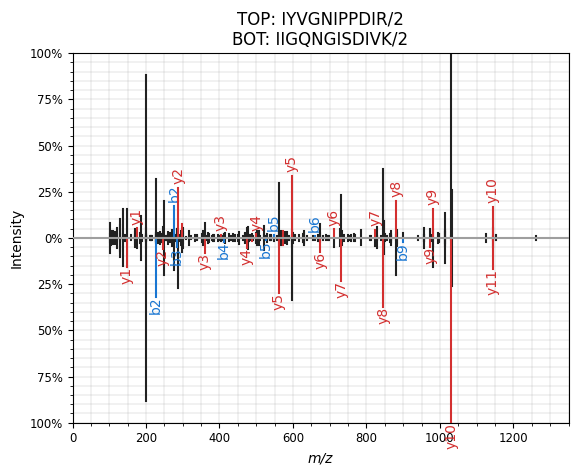

In [274]:
from denovo_utils.analysis.visualization import plot_spectrum
from spectrum_utils import plot as sup

for _, row in ffe.sort_values('n_engines', ascending=False).head(20).iterrows():

    run_name = row['run']
    spectrum_id = row['spectrum_id']

    spectrum = runs[run_name].get_spectrum(
    spectrum_id
    )
    print(spectrum)

    gt_peptide = spectrum.psm_gt.peptidoform.proforma
    dn_peptide = spectrum.top_hit.peptidoform.proforma

    spectrum_gt = plot_spectrum(
        peak_path=os.path.join(root_mgf, f'{run_name}.mgf'),
        spectrum_id=spectrum_id,
        peptide=gt_peptide,
        peak_format='mgf',
        plot=False
    )
    spectrum_dn = plot_spectrum(
        peak_path=os.path.join(root_mgf, f'{run_name}.mgf'),
        spectrum_id=spectrum_id,
        peptide=dn_peptide,
        peak_format='mgf',
        plot=False
    )

    sup.mirror(
        spectrum_gt,
        spectrum_dn
    )
    plt.title(f'TOP: {gt_peptide}\nBOT: {dn_peptide}')
    plt.show()

---

# Overlap section:

Plot the 100% de novo agreement, yet non-matching PSMs for 9 spectra

In [311]:
run_name = 'LFQ_Orbitrap_DDA_Ecoli_01'
examples = [
    'controllerType=0 controllerNumber=1 scan=68814_IAATIAQIPDQIQK/2',
    'controllerType=0 controllerNumber=1 scan=50248_VAAIEGDVIGSYQHQR/2',
    'controllerType=0 controllerNumber=1 scan=86781_DVAGYAAGIEFIDR/2',
    'controllerType=0 controllerNumber=1 scan=26564_ENTEGEYSSINR/2',
    'controllerType=0 controllerNumber=1 scan=39696_ITGVSEEIQTR/2',
    'controllerType=0 controllerNumber=1 scan=85939_FNEIGSITETIAAIK/2',
    'controllerType=0 controllerNumber=1 scan=73519_NFFEEDQIIR/2',
    'controllerType=0 controllerNumber=1 scan=81300_FGGYAESGIIAEITPDK/2',
    'controllerType=0 controllerNumber=1 scan=57934_EIANVQDITVR/2',
    'controllerType=0 controllerNumber=1 scan=58185_IIVVEDAEPIR/2',
    'controllerType=0 controllerNumber=1 scan=56626_SYYAIAEVSK/2',
    'controllerType=0 controllerNumber=1 scan=50738_AIAAAIEGIQK/2',
    'controllerType=0 controllerNumber=1 scan=28877_QEIEEATSDYDR/2',
    'controllerType=0 controllerNumber=1 scan=36667_ADEIQIYK/2',
    'controllerType=0 controllerNumber=1 scan=43426_NADAITIQAPAQR/2',
]
examples = [
    x.split('_') for x in examples
]

Spectrum ID: controllerType=0 controllerNumber=1 scan=68814
Ground-truth: LAATIAQLPDQIGAK/2 ({'peptide': {'sage': 2.8144891262054443, 'score_ms2rescore': 2.8144891262054443}, 'aa': {}})
Candidates:
	LAATLAQLPDQLQK/2 ({'peptide': {'AdaNovo': 0.9963812232017517, 'score_ms2rescore': 3.942217109577355}, 'aa': {'AdaNovo': (0.97921, 0.99551, 0.99816, 0.99775, 0.99423, 0.99819, 0.99819, 0.99719, 0.99819, 0.99819, 0.99819, 0.99816, 0.99817, 0.99819)}})
	LAATLAQLPDQLQK/2 ({'peptide': {'pi-HelixNovo': 0.9900000095367432, 'score_ms2rescore': 3.942217109577355}, 'aa': {}})
	LAATLAQLPDQLQK/2 ({'peptide': {'pi-PrimeNovo': 0.9961528182029724, 'score_ms2rescore': 3.942217109577355}, 'aa': {}})
	LAATLAQLPDQLQK/2 ({'peptide': {'casanovo': 0.9838773608207703, 'score_ms2rescore': 3.942217109577355}, 'aa': {'casanovo': (0.98654, 0.9734, 0.98689, 0.98587, 0.9729, 0.98714, 0.98693, 0.98304, 0.98728, 0.98691, 0.98666, 0.98517, 0.97521, 0.9871)}})
	LAATLAQLPDQLQK/2 ({'peptide': {'instanovo': -0.447698086500167

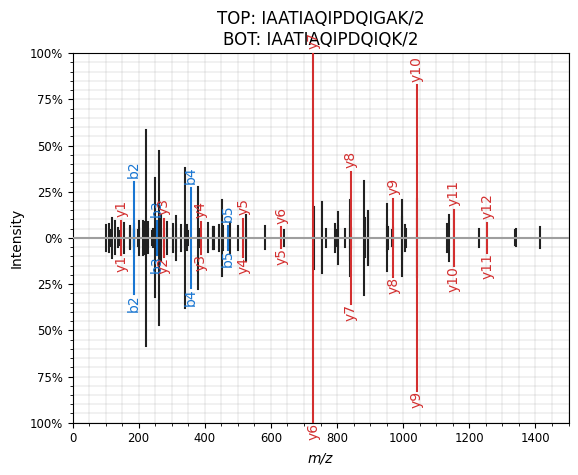

Spectrum ID: controllerType=0 controllerNumber=1 scan=50248
Ground-truth: VAALEGDVLGSYQH<GA>R/2 ({'peptide': {'sage': 6.5093488693237305, 'score_ms2rescore': 6.5093488693237305}, 'aa': {}})
Candidates:
	VAALEGDVLGSYQHQR/2 ({'peptide': {'AdaNovo': 0.9894651174545288, 'score_ms2rescore': 5.94951164879292}, 'aa': {'AdaNovo': (0.99463, 0.94613, 0.99472, 0.99367, 0.99471, 0.99473, 0.99473, 0.99473, 0.99473, 0.99466, 0.99473, 0.99473, 0.99473, 0.99473, 0.95507, 0.99473)}})
	VAALEGDVLGSYQHQR/2 ({'peptide': {'pi-HelixNovo': 0.9700000286102295, 'score_ms2rescore': 5.94951164879292}, 'aa': {}})
	VAALEGDVLGSYQHQR/2 ({'peptide': {'pi-PrimeNovo': 0.9869339466094971, 'score_ms2rescore': 5.94951164879292}, 'aa': {}})
	VAALEGDVLGSYQHQR/2 ({'peptide': {'casanovo': 0.9860333800315857, 'score_ms2rescore': 5.94951164879292}, 'aa': {'casanovo': (0.98902, 0.98518, 0.98826, 0.97463, 0.98848, 0.98747, 0.98763, 0.98773, 0.9887, 0.97537, 0.98685, 0.98328, 0.98822, 0.98838, 0.98689, 0.98808)}})
	VAALEGDVLGSYQHQR

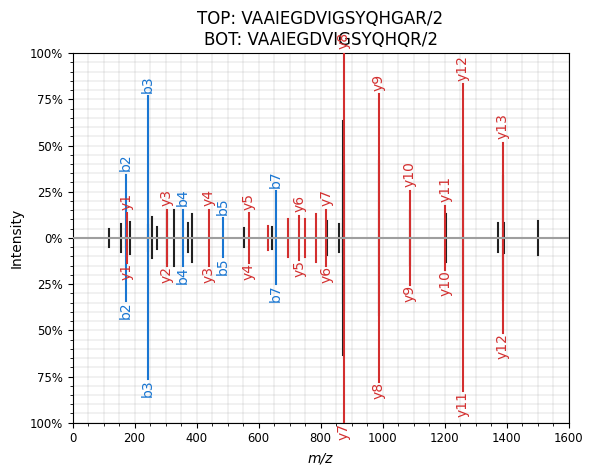

Spectrum ID: controllerType=0 controllerNumber=1 scan=86781
Ground-truth: <DV>AGYAAGLE<LFD>R/2 ({'peptide': {'sage': 2.393972396850586, 'score_ms2rescore': 2.393972396850586}, 'aa': {}})
Candidates:
	<DV>AGYAAGLE<FLD>R/2 ({'peptide': {'AdaNovo': 0.9734188318252563, 'score_ms2rescore': 1.7170195326392914}, 'aa': {'AdaNovo': (0.97163, 0.82745, 0.96275, 0.9864, 0.98634, 0.98669, 0.9867, 0.98666, 0.9867, 0.98668, 0.98671, 0.98671, 0.98669, 0.98646)}})
	<DV>AGYAAGLE<FLD>R/2 ({'peptide': {'pi-HelixNovo': 0.9300000071525574, 'score_ms2rescore': 1.7170195326392914}, 'aa': {}})
	<DV>AGYAAGLE<FLD>R/2 ({'peptide': {'pi-PrimeNovo': 0.21573065221309662, 'score_ms2rescore': 1.7170195326392914}, 'aa': {}})
	<DV>AGYAAGLE<FLD>R/2 ({'peptide': {'casanovo': 0.9400109648704529, 'score_ms2rescore': 1.7170195326392914}, 'aa': {'casanovo': (0.96457, 0.64912, 0.92245, 0.96216, 0.96031, 0.96503, 0.9655, 0.9651, 0.96523, 0.96409, 0.96706, 0.96473, 0.96581, 0.95363)}})
	<DV>AGYAAGLE<FLD>R/2 ({'peptide': {'instan

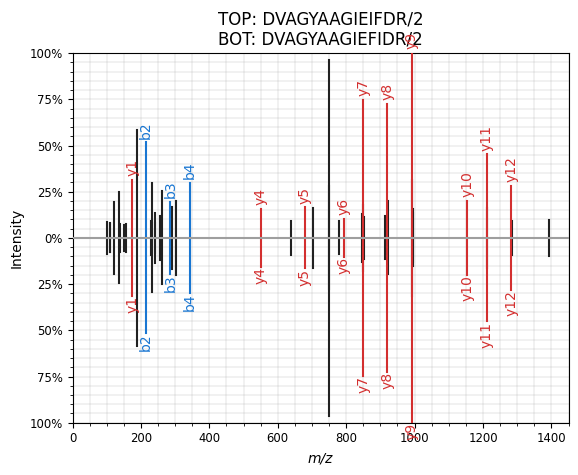

Spectrum ID: controllerType=0 controllerNumber=1 scan=26564
Ground-truth: ENTEGEYSSL<GG>R/2 ({'peptide': {'sage': 3.320117950439453, 'score_ms2rescore': 3.320117950439453}, 'aa': {}})
Candidates:
	ENTEGEYSSLNR/2 ({'peptide': {'AdaNovo': 0.9911561012268066, 'score_ms2rescore': 2.6875990017745353}, 'aa': {'AdaNovo': (0.98801, 0.95413, 0.99038, 0.99541, 0.99553, 0.99551, 0.99543, 0.99558, 0.99557, 0.99557, 0.993, 0.99533)}})
	ENTEGEYSSLNR/2 ({'peptide': {'pi-HelixNovo': 0.949999988079071, 'score_ms2rescore': 2.6875990017745353}, 'aa': {}})
	ENTEGEYSSLNR/2 ({'peptide': {'pi-PrimeNovo': 0.9275187849998474, 'score_ms2rescore': 2.6875990017745353}, 'aa': {}})
	ENTEGEYSSLNR/2 ({'peptide': {'casanovo': 0.9796395301818848, 'score_ms2rescore': 2.6875990017745353}, 'aa': {'casanovo': (0.9772, 0.95718, 0.98436, 0.98588, 0.98412, 0.9857, 0.972, 0.9845, 0.97886, 0.98505, 0.98193, 0.97346)}})
	ENTEGEYSSLNR/2 ({'peptide': {'instanovo': -0.14074480533599854, 'score_ms2rescore': 2.6875990017745353}, 'aa'

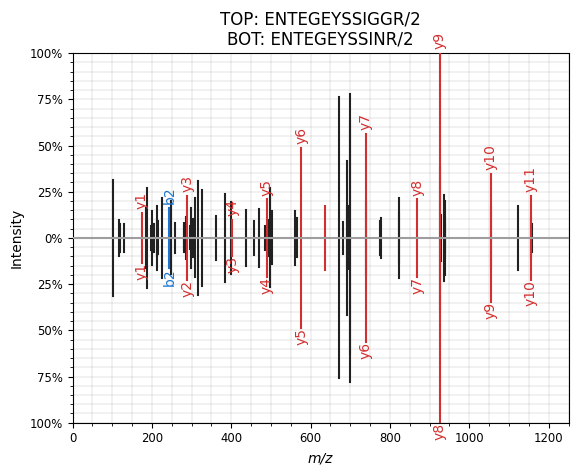

Spectrum ID: controllerType=0 controllerNumber=1 scan=39696
Ground-truth: LTGVSEEL<GA>TR/2 ({'peptide': {'sage': 3.435713291168213, 'score_ms2rescore': 3.435713291168213}, 'aa': {}})
Candidates:
	LTGVSEELQTR/2 ({'peptide': {'AdaNovo': 0.9341304898262024, 'score_ms2rescore': 3.3155428512415894}, 'aa': {'AdaNovo': (0.66014, 0.93947, 0.90802, 0.96704, 0.96598, 0.96663, 0.96702, 0.96701, 0.96706, 0.96707, 0.96707)}})
	LTGVSEELQTR/2 ({'peptide': {'pi-HelixNovo': 0.9599999785423279, 'score_ms2rescore': 3.3155428512415894}, 'aa': {}})
	LTGVSEELQTR/2 ({'peptide': {'pi-PrimeNovo': 0.9198154211044312, 'score_ms2rescore': 3.3155428512415894}, 'aa': {}})
	LTGVSEELQTR/2 ({'peptide': {'casanovo': 0.984096348285675, 'score_ms2rescore': 3.3155428512415894}, 'aa': {'casanovo': (0.98311, 0.97995, 0.98449, 0.98706, 0.97322, 0.97897, 0.98738, 0.98531, 0.98748, 0.98766, 0.98727)}})
	LTGVSEELQTR/2 ({'peptide': {'instanovo': -0.34241536259651184, 'score_ms2rescore': 3.3155428512415894}, 'aa': {}})
	LTGVSEELQ

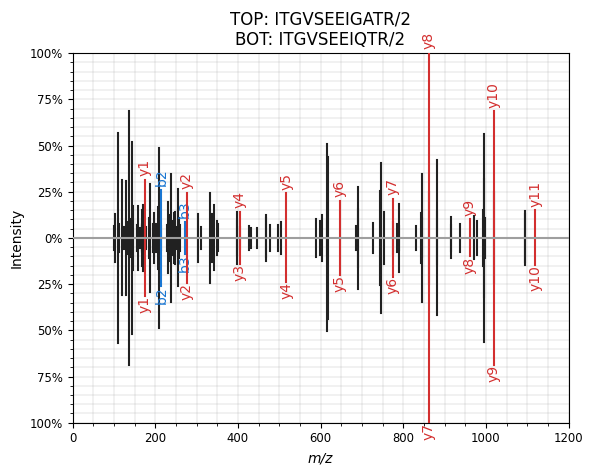

Spectrum ID: controllerType=0 controllerNumber=1 scan=85939
Ground-truth: FNQIGSLTETLA<AI>K/2 ({'peptide': {'sage': 2.1577255725860596, 'score_ms2rescore': 2.1577255725860596}, 'aa': {}})
Candidates:
	FNELGSLTETLA<AL>K/2 ({'peptide': {'AdaNovo': 0.9828310608863831, 'score_ms2rescore': 3.5306896342151064}, 'aa': {'AdaNovo': (0.99117, 0.93514, 0.99103, 0.99113, 0.99139, 0.99139, 0.99139, 0.99141, 0.9914, 0.99142, 0.99142, 0.99141, 0.91544, 0.98732, 0.99142)}})
	FNELGSLTETLA<AL>K/2 ({'peptide': {'pi-HelixNovo': 0.949999988079071, 'score_ms2rescore': 3.5306896342151064}, 'aa': {}})
	FNELGSLTETLA<AL>K/2 ({'peptide': {'pi-PrimeNovo': 0.9260241389274597, 'score_ms2rescore': 3.5306896342151064}, 'aa': {}})
	FNELGSLTETLA<AL>K/2 ({'peptide': {'casanovo': 0.9852197170257568, 'score_ms2rescore': 3.5306896342151064}, 'aa': {'casanovo': (0.98831, 0.98623, 0.98792, 0.98839, 0.98824, 0.98821, 0.98646, 0.9875, 0.98745, 0.98757, 0.98813, 0.98774, 0.95326, 0.9827, 0.98732)}})
	FNELGSLTETLA<AL>K/2 ({'pept

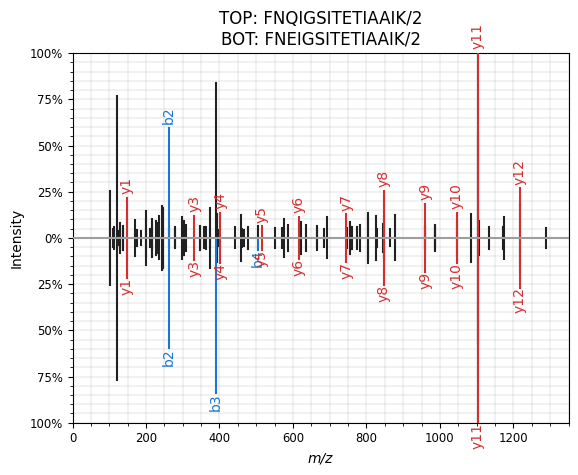

Spectrum ID: controllerType=0 controllerNumber=1 scan=73519
Ground-truth: <NF>FEED<LQ>IR/2 ({'peptide': {'sage': 2.166872262954712, 'score_ms2rescore': 2.166872262954712}, 'aa': {}})
Candidates:
	<NF>FEED<QL>LR/2 ({'peptide': {'AdaNovo': 0.9889294505119324, 'score_ms2rescore': 2.471487463087379}, 'aa': {'AdaNovo': (0.99382, 0.99022, 0.94117, 0.99395, 0.99436, 0.99443, 0.99442, 0.99446, 0.99446, 0.99245)}})
	<NF>FEED<QL>LR/2 ({'peptide': {'pi-HelixNovo': 0.9700000286102295, 'score_ms2rescore': 2.471487463087379}, 'aa': {}})
	<NF>FEED<QL>LR/2 ({'peptide': {'pi-PrimeNovo': 0.8270955085754395, 'score_ms2rescore': 2.471487463087379}, 'aa': {}})
	<NF>FEED<QL>LR/2 ({'peptide': {'casanovo': 0.9579157829284668, 'score_ms2rescore': 2.471487463087379}, 'aa': {'casanovo': (0.97425, 0.97271, 0.83378, 0.97383, 0.9672, 0.96383, 0.96343, 0.97427, 0.97255, 0.96747)}})
	<NF>FEED<QL>LR/2 ({'peptide': {'instanovo': -0.1790100783109665, 'score_ms2rescore': 2.471487463087379}, 'aa': {}})
	<NF>FEED<QL>LR/2 (

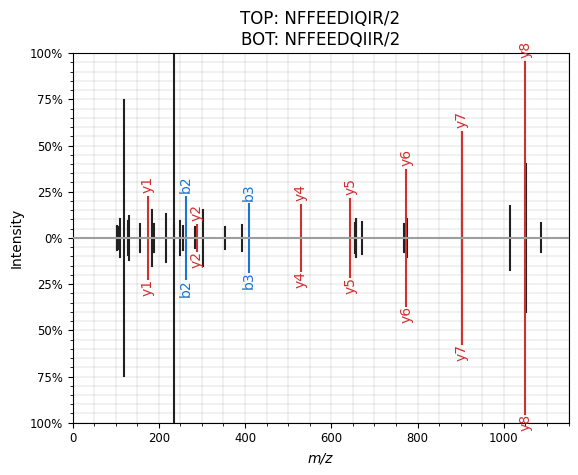

Spectrum ID: controllerType=0 controllerNumber=1 scan=81300
Ground-truth: FGGYAQS<GL>LAEIT<PD>K/2 ({'peptide': {'sage': 2.3629159927368164, 'score_ms2rescore': 2.3629159927368164}, 'aa': {}})
Candidates:
	FGGYAES<GL>LAELT<PD>K/2 ({'peptide': {'AdaNovo': 0.9986855983734131, 'score_ms2rescore': 4.4110369001708385}, 'aa': {'AdaNovo': (0.99915, 0.99561, 0.99934, 0.99934, 0.99925, 0.99927, 0.99934, 0.99934, 0.99915, 0.99934, 0.99934, 0.99934, 0.99934, 0.99525, 0.99934, 0.99591, 0.99934)}})
	FGGYAES<GL>LAELT<PD>K/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 4.4110369001708385}, 'aa': {}})
	FGGYAES<GL>LAELT<PD>K/2 ({'peptide': {'pi-PrimeNovo': 0.9154885411262512, 'score_ms2rescore': 4.4110369001708385}, 'aa': {}})
	FGGYAES<GL>LAELT<PD>K/2 ({'peptide': {'casanovo': 0.9873737692832947, 'score_ms2rescore': 4.4110369001708385}, 'aa': {'casanovo': (0.98847, 0.98616, 0.98826, 0.98802, 0.98919, 0.98016, 0.98958, 0.98809, 0.98197, 0.98908, 0.9882, 0.98199, 0.98881, 0.98804,

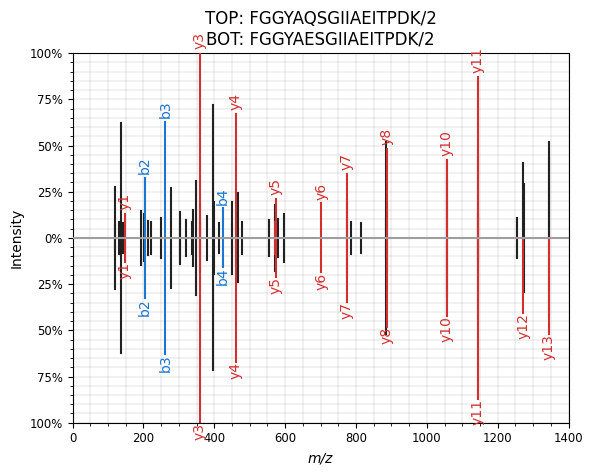

Spectrum ID: controllerType=0 controllerNumber=1 scan=57934
Ground-truth: <GQ>DIIALDVQGK/2 ({'peptide': {'sage': 3.311596155166626, 'score_ms2rescore': 3.311596155166626}, 'aa': {}})
Candidates:
	ELANVQDLTVR/2 ({'peptide': {'AdaNovo': 0.9627109169960022, 'score_ms2rescore': 2.526944877503372}, 'aa': {'AdaNovo': (0.76884, 0.97472, 0.98034, 0.98134, 0.98129, 0.98058, 0.98106, 0.97898, 0.98133, 0.98136, 0.98134)}})
	ELANVQDLTVR/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 2.526944877503372}, 'aa': {}})
	ELANVQDLTVR/2 ({'peptide': {'pi-PrimeNovo': 0.956616222858429, 'score_ms2rescore': 2.526944877503372}, 'aa': {}})
	ELANVQDLTVR/2 ({'peptide': {'casanovo': 0.9855519533157349, 'score_ms2rescore': 2.526944877503372}, 'aa': {'casanovo': (0.98803, 0.98711, 0.98905, 0.98803, 0.97267, 0.98648, 0.98809, 0.98576, 0.98821, 0.98892, 0.97648)}})
	ELANVQDLTVR/2 ({'peptide': {'instanovo': -0.4171147346496582, 'score_ms2rescore': 2.526944877503372}, 'aa': {}})
	ELANVQDLTVR/2 (

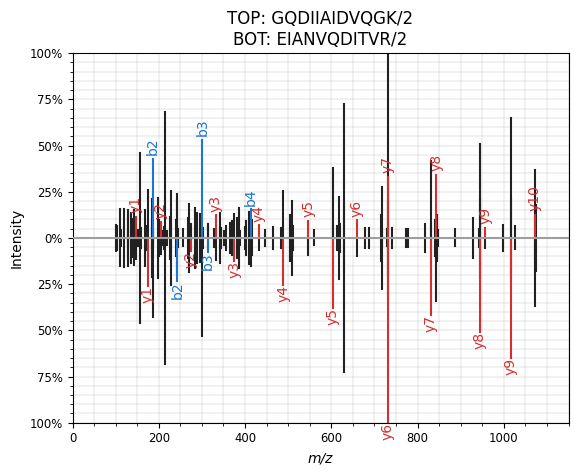

Spectrum ID: controllerType=0 controllerNumber=1 scan=58185
Ground-truth: ILVVED<EA><PI>R/2 ({'peptide': {'sage': 2.2798662185668945, 'score_ms2rescore': 2.2798662185668945}, 'aa': {}})
Candidates:
	LLVVED<AE><PL>R/2 ({'peptide': {'AdaNovo': 0.9815216064453125, 'score_ms2rescore': 1.484914402969924}, 'aa': {'AdaNovo': (0.93374, 0.93836, 0.9905, 0.98981, 0.9907, 0.99064, 0.99071, 0.99076, 0.99076, 0.99076, 0.99076)}})
	LLVVED<AE><PL>R/2 ({'peptide': {'pi-HelixNovo': 0.949999988079071, 'score_ms2rescore': 1.484914402969924}, 'aa': {}})
	LLVVED<AE><PL>R/2 ({'peptide': {'pi-PrimeNovo': 0.9483861327171326, 'score_ms2rescore': 1.484914402969924}, 'aa': {}})
	LLVVED<AE><PL>R/2 ({'peptide': {'casanovo': 0.9593077301979065, 'score_ms2rescore': 1.484914402969924}, 'aa': {'casanovo': (0.8597, 0.96945, 0.97236, 0.95732, 0.97526, 0.94704, 0.95918, 0.97479, 0.9743, 0.97471, 0.97279)}})
	LLVVED<AE><PL>R/2 ({'peptide': {'instanovo': -0.15642884373664856, 'score_ms2rescore': 1.484914402969924}, 'aa': {

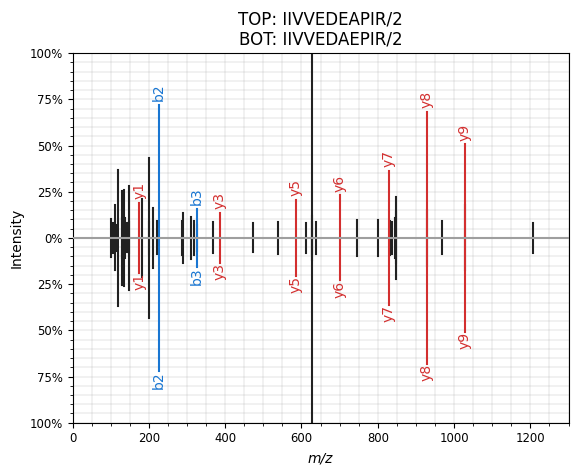

None
Spectrum ID: controllerType=0 controllerNumber=1 scan=50738
Ground-truth: <AL>AAAL<GQ>IEK/2 ({'peptide': {'sage': 3.0544216632843018, 'score_ms2rescore': 3.0544216632843018}, 'aa': {}})
Candidates:
	<AL>AAALEGLQK/2 ({'peptide': {'AdaNovo': 0.9945201873779297, 'score_ms2rescore': 2.8101674512064503}, 'aa': {'AdaNovo': (0.99698, 0.99373, 0.9964, 0.99461, 0.9958, 0.99721, 0.99721, 0.99725, 0.99726, 0.97328, 0.99726)}})
	<AL>AAALEGLQK/2 ({'peptide': {'pi-HelixNovo': 0.9700000286102295, 'score_ms2rescore': 2.8101674512064503}, 'aa': {}})
	<AL>AAALEGLQK/2 ({'peptide': {'pi-PrimeNovo': 0.9561243057250977, 'score_ms2rescore': 2.8101674512064503}, 'aa': {}})
	<AL>AAALEGLQK/2 ({'peptide': {'casanovo': 0.9706345796585083, 'score_ms2rescore': 2.8101674512064503}, 'aa': {'casanovo': (0.9806, 0.97981, 0.97616, 0.97909, 0.93695, 0.98064, 0.98043, 0.98027, 0.98029, 0.91248, 0.98037)}})
	<AL>AAALEGLQK/2 ({'peptide': {'instanovo': -0.019638940691947937, 'score_ms2rescore': 2.8101674512064503}, 'aa'

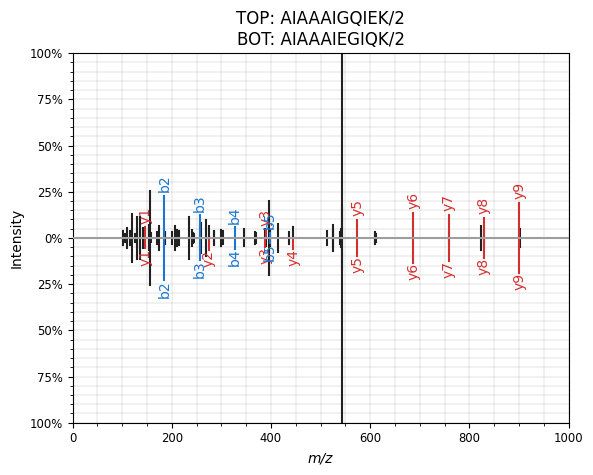

Spectrum ID: controllerType=0 controllerNumber=1 scan=28877
Ground-truth: QQIEEAT<SD><YD>R/2 ({'peptide': {'sage': 1.309416651725769, 'score_ms2rescore': 1.309416651725769}, 'aa': {}})
Candidates:
	QELEEATSD<YD>R/2 ({'peptide': {'AdaNovo': 0.9995565414428711, 'score_ms2rescore': 1.6538810064962697}, 'aa': {'AdaNovo': (0.99918, 0.99946, 0.99974, 0.99952, 0.99955, 0.99978, 0.99978, 0.99977, 0.99971, 0.99977, 0.99869, 0.9995)}})
	QELEEATSD<YD>R/2 ({'peptide': {'pi-HelixNovo': 0.9900000095367432, 'score_ms2rescore': 1.6538810064962697}, 'aa': {}})
	QELEEATSD<YD>R/2 ({'peptide': {'pi-PrimeNovo': 0.8848837018013, 'score_ms2rescore': 1.6538810064962697}, 'aa': {}})
	QELEEATSD<YD>R/2 ({'peptide': {'casanovo': 0.9783880114555359, 'score_ms2rescore': 1.6538810064962697}, 'aa': {'casanovo': (0.98482, 0.94755, 0.98468, 0.9858, 0.98588, 0.98409, 0.98458, 0.97774, 0.97701, 0.98419, 0.96699, 0.97125)}})
	QELEEATSD<YD>R/2 ({'peptide': {'instanovo': -0.035143546760082245, 'score_ms2rescore': 1.65388100

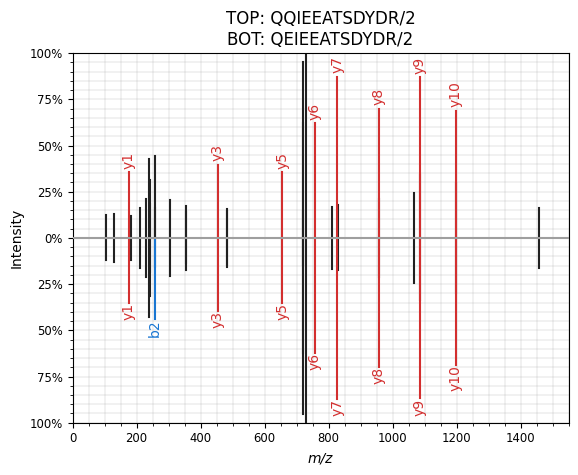

Spectrum ID: controllerType=0 controllerNumber=1 scan=36667
Ground-truth: <AY>DLGADVR/2 ({'peptide': {'sage': 1.964503526687622, 'score_ms2rescore': 1.964503526687622}, 'aa': {}})
Candidates:
	ADELQLYK/2 ({'peptide': {'AdaNovo': 0.9732363224029541, 'score_ms2rescore': 1.113537255164291}, 'aa': {'AdaNovo': (0.88827, 0.96662, 0.98658, 0.98489, 0.98656, 0.98642, 0.98655, 0.98662)}})
	ADELQLYK/2 ({'peptide': {'pi-HelixNovo': 0.9800000190734863, 'score_ms2rescore': 1.113537255164291}, 'aa': {}})
	ADELQLYK/2 ({'peptide': {'pi-PrimeNovo': 0.39553433656692505, 'score_ms2rescore': 1.113537255164291}, 'aa': {}})
	ADELQLYK/2 ({'peptide': {'casanovo': 0.9875582456588745, 'score_ms2rescore': 1.113537255164291}, 'aa': {'casanovo': (0.9885, 0.98753, 0.98873, 0.98893, 0.98903, 0.98585, 0.98175, 0.98909)}})
	ADELQLYK/2 ({'peptide': {'instanovo': -0.01130602601915598, 'score_ms2rescore': 1.113537255164291}, 'aa': {}})
	ADELQLYK/2 ({'peptide': {'contranovo': 0.9994245171546936, 'score_ms2rescore': 1.1135

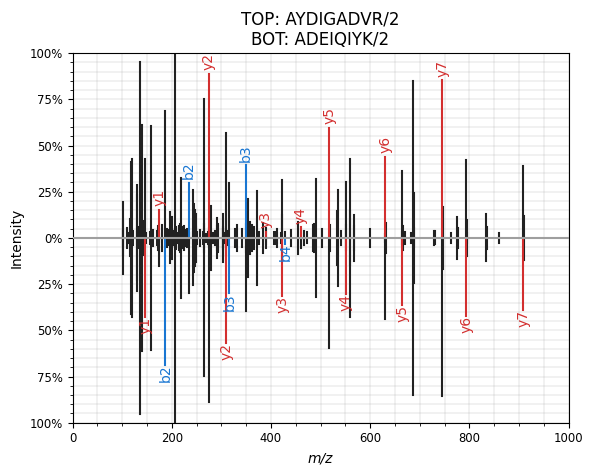

Spectrum ID: controllerType=0 controllerNumber=1 scan=43426
Ground-truth: ALAEHGIVFGEPK/2 ({'peptide': {'sage': 6.695902347564697, 'score_ms2rescore': 6.695902347564697}, 'aa': {}})
Candidates:
	NADALTLQAPAQR/2 ({'peptide': {'AdaNovo': 0.9672532677650452, 'score_ms2rescore': 4.466442148617467}, 'aa': {'AdaNovo': (0.82434, 0.92061, 0.98361, 0.98363, 0.98363, 0.98118, 0.98363, 0.98363, 0.98363, 0.98363, 0.98202, 0.98362, 0.98078)}})
	NADALTLQAPAQR/2 ({'peptide': {'pi-HelixNovo': 1.0, 'score_ms2rescore': 4.466442148617467}, 'aa': {}})
	NADALTLQAPAQR/2 ({'peptide': {'pi-PrimeNovo': 0.9964955449104309, 'score_ms2rescore': 4.466442148617467}, 'aa': {}})
	NADALTLQAPAQR/2 ({'peptide': {'casanovo': 0.9902153611183167, 'score_ms2rescore': 4.466442148617467}, 'aa': {'casanovo': (0.99005, 0.99105, 0.98925, 0.9909, 0.99111, 0.99002, 0.99053, 0.99073, 0.99016, 0.99015, 0.98788, 0.99076, 0.98987)}})
	NADALTLQAPAQR/2 ({'peptide': {'instanovo': -0.6773501038551331, 'score_ms2rescore': 4.466442148617467

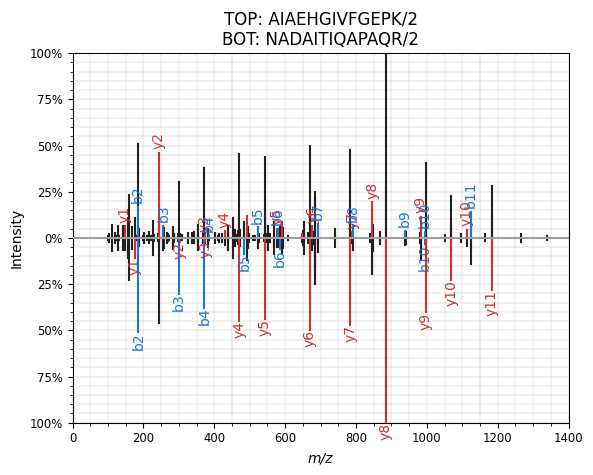

In [315]:
from denovo_utils.analysis.visualization import plot_spectrum
from spectrum_utils import plot as sup

for (spectrum_id, peptide) in examples:
    spectrum = runs[run_name].get_spectrum(spectrum_id)
    print(spectrum)

    if spectrum == None:
        continue

    gt_peptide = spectrum.psm_gt.peptidoform.proforma
    dn_peptide = spectrum.top_hit.peptidoform.proforma

    spectrum_gt = plot_spectrum(
        peak_path=os.path.join(root_mgf, f'{run_name}.mgf'),
        spectrum_id=spectrum_id,
        peptide=gt_peptide,
        peak_format='mgf',
        plot=False
    )
    spectrum_dn = plot_spectrum(
        peak_path=os.path.join(root_mgf, f'{run_name}.mgf'),
        spectrum_id=spectrum_id,
        peptide=dn_peptide,
        peak_format='mgf',
        plot=False
    )

    sup.mirror(
        spectrum_gt,
        spectrum_dn
    )
    plt.title(f'TOP: {gt_peptide}\nBOT: {dn_peptide}')
    plt.show()

In [310]:
examples

[['controllerType=0 controllerNumber=1 scan=68814', 'IAATIAQIPDQIQK/2'],
 ['controllerType=0 controllerNumber=1 scan=50248', 'VAAIEGDVIGSYQHQR/2'],
 ['controllerType=0 controllerNumber=1 scan=86781', 'DVAGYAAGIEFIDR/2'],
 ['controllerType=0 controllerNumber=1 scan=26564', 'ENTEGEYSSINR/2'],
 ['controllerType=0 controllerNumber=1 scan=39696', 'ITGVSEEIQTR/2'],
 ['controllerType=0 controllerNumber=1 scan=85939', 'FNEIGSITETIAAIK/2'],
 ['controllerType=0 controllerNumber=1 scan=73519', 'NFFEEDQIIR/2'],
 ['controllerType=0 controllerNumber=1 scan=81300', 'FGGYAESGIIAEITPDK/2'],
 ['controllerType=0 controllerNumber=1 scan=57934', 'EIANVQDITVR/2'],
 ['controllerType=0 controllerNumber=1 scan=58185', 'IIVVEDAEPIR/2'],
 ['controllerType=0 controllerNumber=1 scan=56626', 'SYYAIAEVSK/2'],
 ['controllerType=0 controllerNumber=1 scan=50738', 'AIAAAIEGIQK/2'],
 ['controllerType=0 controllerNumber=1 scan=28877', 'QEIEEATSDYDR/2'],
 ['controllerType=0 controllerNumber=1 scan=36667', 'ADEIQIYK/2'],
 [